In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm, LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable, ImageGrid
from matplotlib.patches import Ellipse, Rectangle
from matplotlib.lines import Line2D
import os
from tqdm import tqdm
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.convolution import Gaussian2DKernel

In [2]:
plt.rcParams['mathtext.fontset'] = 'stixsans'
plt.rcParams['font.family'] = 'sans'
plt.rcParams['font.serif'] = 'STIXGeneral'
plt.rcParams['font.size'] = 12.0

# Import images

In this notebook we look at detections across different bands, namely:
1. H-band: F160
2. I-band: F814

In [3]:
def import_fits(path, name):
    sci = fits.open(os.path.join(path, name+"sci.fits"))
    wht = fits.open(os.path.join(path, name+"wht.fits"))
    image = sci[0].data
    image = image.byteswap().newbyteorder()
    weight = wht[0].data
    weight = weight.byteswap().newbyteorder()
    wcs = WCS(sci[0].header)
    return image, weight, wcs

def get_cutout(image, weight, wcs, position, size):
    cutout_image = Cutout2D(image, position, size, wcs=wcs)
    cutout_weight = Cutout2D(weight, position, size, wcs=wcs)
    image = np.ascontiguousarray(cutout_image.data)
    weight = np.ascontiguousarray(cutout_weight.data)
    rms = np.sqrt(1.0/weight)
    return image, weight, rms, cutout_image

In [4]:
base = "/home/max/Development/semester-project/data/"
hband = "hlsp_xdf_hst_wfc3ir-60mas_hudf_f160w_v1_"
iband = "hlsp_xdf_hst_acswfc-60mas_hudf_f814w_v1_"
sci_h, wht_h, wcs_h = import_fits(base, hband)
sci_i, wht_i, wcs_i = import_fits(base, iband)

In [5]:
position = (3020, 3470)
size = (500, 500)
image_h, weight_h, rms_h, cutout_h = get_cutout(sci_h, wht_h, wcs_h, position, size)
image_i, weight_i, rms_i, cutout_i = get_cutout(sci_i, wht_i, wcs_i, position, size)

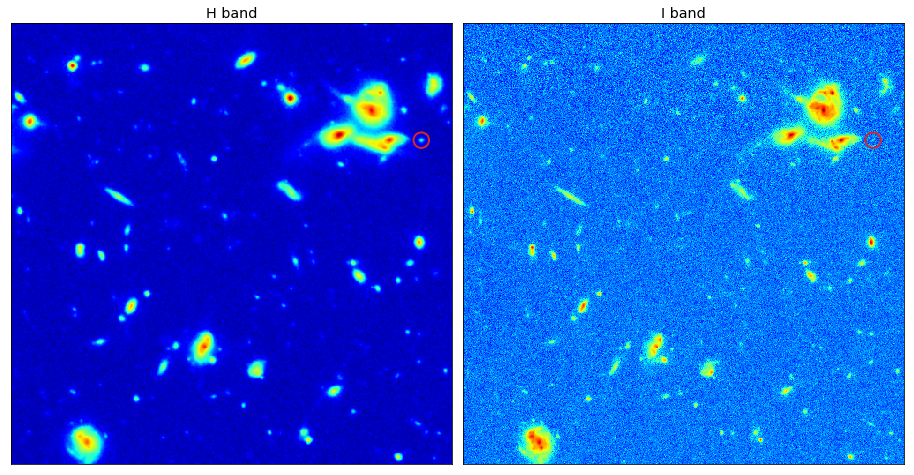

In [6]:
fig = plt.figure(figsize=(16, 12))
grid = ImageGrid(fig, 111, nrows_ncols=(1,2), axes_pad=0.15, share_all=True)#, cbar_location="right", \
                 #cbar_mode="single", cbar_size="7%", cbar_pad=0.15)
images = [image_h, image_i]
titles = ["H band", "I band"]
for (i,ax) in enumerate(grid):
    ax.set_title(titles[i])
    ax.scatter(465, 367, s=240, linewidth=2, edgecolor='C3', facecolor='none')
    im = ax.imshow(images[i], interpolation='nearest', cmap='jet', norm=SymLogNorm(linthresh=1e-2), origin='lower')
ax.xaxis.set_major_locator(plt.NullLocator())
ax.yaxis.set_major_locator(plt.NullLocator())
#ax.cax.colorbar(im)
#ax.cax.toggle_label(True)
fig.savefig("images/H-I-bands.png", bbox_inches='tight')
fig.savefig("images/H-I-bands.pdf", bbox_inches='tight')

# Source extraction

We run SExctactor on both bands in different modes and then compare the detections. In both cases we set the following parameters:
- `MINCONT = 1e-7`
- `NTHRESH = 64`

Each mode has a different kernel, which allows us to target specific objects during the detection process.

## `MultiModeSourceExtractor` class

In [7]:
%%file mmse.py

import numpy as np
import pandas as pd
import sep
import hashlib

class MultiModeSourceExtractor():
    def __init__(self, modes, bands):
        """
        Initialize MultiModeSourceExtractor instance with modes for each band
        
        Args:
            - modes (dict): dictionary with band names as keys and a list of parameters
                            for each mode as values
            - bands (dict): dictionary with band names as keys and band dictionary as values.
                            Band dictionary needs to have an image and an rms field
        """
        # check if parameters are dictionaries
        if not isinstance(modes, dict):
            raise TypeError("Parameter modes must be a dictionary")
        if not isinstance(bands, dict):
            raise TypeError("Parameter bands must be a dictionary")
        # check if name of bands in modes corresponds with those in bands
        if not set(modes.keys()).issubset(bands.keys()):
            raise ValueError("Names of bands in modes and bands dict do not match")
        # check if image and rms maps in bands have same dimension
        keys = bands.keys()
        for key in keys:
            if not bands[key]['image'].shape == bands[key]['rms'].shape:
                raise ValueError("Shape of image and rms maps in band {} do not match".format(key))
        # check that all bands have same dimensions
        image_shapes = [band['image'].shape for band in bands.values()]
        rms_shapes = [band['rms'].shape for band in bands.values()]
        if not len(set(image_shapes)) == 1:
            raise ValueError("image maps do not have same shape in all bands")
        if not len(set(rms_shapes)) == 1:
            raise ValueError("rms maps do not have same shape in all bands")
        # checks done, all good: set properties and columns
        self.modes = modes
        self.bands = bands
        self.shape = image_shapes[0]
        self.columns = ['x', 'y', 'cxx', 'cyy', 'cxy', 'a', 'b', 'theta', 'mode', 'band', 
                       'is_sub', 'main_uid', 'has_subs', 'similar_to', 'keep']

        
    def extract(self):
        """
        Run SExtractor in different modes for each band and collect detections
        for all bands in a Pandas DataFrame with unique id for each detection.
        """
        # run source extraction for every band
        data = []
        index = []
        print("Starting multi mode source extraction on {} bands".format(len(self.bands)))
        for (bid, band) in self.bands.items():
            print("- running source extraction on {} band".format(bid))
            # run source extraction for each mode in band
            for (mid, params) in self.modes[bid].items():
                objects = sep.extract(band['image'], params['sigma'], err=band['rms'], 
                                      deblend_nthresh=params['nthresh'], deblend_cont=params['mincont'],
                                      filter_kernel=params['kernel'], minarea=params['minarea'])
                for o in objects:
                    row = {}
                    index.append(self._generate_uid(o, mid, bid))
                    for c in self.columns[:8]:
                        row[c] = o[c]
                    row['mode'] = mid
                    row['band'] = bid
                    row['is_sub'] = False
                    row['main_uid'] = None
                    row['has_subs'] = False
                    row['similar_to'] = None
                    row['keep'] = None
                    data.append(row)
                print("\t + detected {} sources in {} mode".format(len(objects), mid))
        self.catalog = pd.DataFrame(data=data, columns=self.columns, index=index)
        print("Done! Detect {} objects in total across all bands.".format(self.catalog.shape[0]))
                
            
    def set_flux(self, r=1):
        """
        Commpute flux within an ellipse centered around each object
        
        Args:
            - r (float): radius of ellipse
        """
        fluxes = []
        for obj in self.catalog.itertuples(index=False):
            fluxes.append(self._get_flux(obj))
        self.catalog = self.catalog.assign(flux=fluxes)
            
        
    def find_substructures(self, main_band, main_mode, subs_band, subs_mode, percentile=0.1, r=2):
        """
        Find substructures in subs_band from subs_mode related to top percentile 
        brightest objects in main_band from main_mode
        
        Args:
            - main_band (string): name of main band
            - main_mode (string): name of main mode
            - subs_band (string): name of subs band
            - subs_mode (string): name of subs mode
            - percentile (float): top percent from which to select the objects
            - r (float): radius of ellipse
        """
        if not ('flux' in self.catalog.columns):
            raise RuntimeError("Need to set flux before searching for substrauctures")
        selection, flux_cut = self._get_flux_cut(main_band, main_mode, percentile=percentile)
        print("Looking for substructures in sources with flux count rate >= {:.2f}".format(flux_cut))
        subs = self.catalog[self.catalog['band'].str.match(subs_band) & self.catalog['mode'].str.match(subs_mode)]
        for obj in selection.itertuples():
            print("- substructures for source {}".format(obj.Index))
            ellipse = self._get_ellipse(obj, r=r)
            has_subs = False
            for sub in subs.itertuples():
                if tuple((int(sub.y), int(sub.x))) in ellipse:
                    print("\t + {}".format(sub.Index))
                    self.catalog.loc[sub.Index, 'is_sub'] = True
                    self.catalog.loc[sub.Index, 'main_uid'] = obj.Index
                    has_subs = True
            if has_subs:
                self.catalog.loc[obj.Index, 'has_subs'] = True
                
                
    def find_similar(self, band, mode1, mode2, band2=None, threshold=1e-3):
        """
        Find similar detections across two modes in the same band or in different ones
        
        Args: 
            - band (string): name of (first) band
            - mode1 (string): name of first mode
            - mode2 (string): name of second mode
            - band2 (string): name of (second) band
            - threshold (float): minimal proximity threshold
        """
        if band2==None:
            band2 = band
        objects1 = self.catalog[self.catalog['band'].str.match(band) & self.catalog['mode'].str.match(mode1)]
        objects2 = self.catalog[self.catalog['band'].str.match(band2) & self.catalog['mode'].str.match(mode2)]
        for p in objects1.itertuples():
            for q in objects2.itertuples():
                proximity = self._get_proximity(p, q)
                if proximity < threshold:
                    self.catalog.loc[q.Index, 'similar_to'] = p.Index
                    
    
    def get_positions(self, band='all', mode='all', no_duplicates=True, replace_substructures=True):
        """
        Query the catalog for the (x,y) positions of the detected objects. The parameters allow
        to choose from which band and from which mode to get the objects.
        
        Args:
            - band (string): name of band from which to get the detected objects;
                             'all' returns objects from every band
            - mode (string): name of mode from which to get the detected objects;
                             'all' returns objects from every mode
            - no_duplicates (bool): for similar objects, wheter to return both or not
            - replace_substructures (bool): wheter to replace bright objects with their
                             substructure components
                             
        Returns:
            - positions (dict or np.narray): dict with (x,y) coordinates for each band
                             or Nx2 array with (x,y) coordinates
        """
        # check if parameters are valid
        bids = self.bands.keys()
        mids = []
        for bid in bids:
            mids.extend(list(self.modes[bid].keys()))
        mids = set(mids)
        if (band!='all') and not(band in bids):
            raise ValueError("The band name specified does not exist")
        if (band!='all') and not(mode in mids):
            raise ValueError("The mode name specified does not exist")
        if band=='all' and mode=='all':
            breg = '|'.join(bids)
            mreg = '|'.join(mids)
        else:
            breg = band
            mreg = mode
        # select objects in bands and modes according to specified parameters
        print("Selecting objects from: \n\t + bands: {} \n\t + modes: {}".format(breg, mreg))
        objects = self.catalog[self.catalog['band'].str.match(breg) & self.catalog['mode'].str.match(mreg) & self.catalog['keep']]
        objects = objects.loc[:, ['x', 'y', 'band']]
        """
        # remove duplicates if requested
        if no_duplicates:
            dups = objects[objects['similar_to'].notnull()]
            objects = objects.drop(dups.index)
            print("- removing duplicates: \n\t + {} objects dropped".format(dups.shape[0]))
        # replace substructures if requested
        if replace_substructures:
            mains = objects[objects['has_subs']]
            objects = objects.drop(mains.index)
            print("- replacing substructure: \n\t + {} objects dropped".format(mains.shape[0]))
        """
        # prepare output, if all bands were considered in the previous steps, then return
        # a dictionary with the band ids as keys and the position matrix as values;
        # else simply return a Nx2 matrix with (x,y) coordinates
        if band=='all':
            positions = {}
            for bid in bids:
                positions[bid] = objects[objects['band'].str.match(bid)].as_matrix(columns=['x', 'y'])
        else:
            positions = objects.as_matrix(columns=['x', 'y'])
        return positions
    
    
    def keep(self, uids):
        """
        Set keep flag to True for objects with uid in uids
        
        Args:
            - uids (list): list of uid indices
        """
        self.catalog.loc[uids, 'keep'] = True
        
    
    def discard(self, uids):
        """
        Set keep flag to False for objects with uid in uids
        
        Args:
            - uids (list): list of uid indices
        """
        self.catalog.loc[uids, 'keep'] = False
            
            
    def _generate_uid(self, obj, mode, band):
        """
        Generate a unique id for the detected object, using its parameters as seed
        for the hash function
        
        Args:
            - obj (np.narray): detected object as structured array
            - mode (string): name of mode in which the object was detected
            - band (string): name of band in which the object was detected
        
        Returns:
            - uid (string): md5 hash
        """
        seed = ""
        for c in self.columns[:8]:
            seed += str(obj[c])
        seed += mode+band
        return hashlib.md5(seed.encode('utf-8')).hexdigest()
    
    
    def _get_ellipse(self, obj, r=1):
        """
        Find the set of pixel that satisfy the ellipse inequality:
         CXX*(x-xb)**2+CYY*(y-yb)**2+CXY*(x-xb)*(y-yb)<=r**2
         
        Args:
            - obj (np.narray): detected object as structured array
            - r (float): radius of ellipse
            
        Returns:
            - ellipse (set): set of pixel satisfying the above inequality
        """
        ellipse = []
        w1, w2 = 50, 50
        h1, h2 = 50, 50
        if (obj.x < w1):
            w1 = int(obj.x)
        if (obj.x >= self.shape[1]-w2):
            w2 = self.shape[1]-int(obj.x)
        if (obj.y < h1):
            w1 = int(obj.y)
        if (obj.y >= self.shape[0]-h2):
            w2 = self.shape[0]-int(obj.y)
        for y in range(int(obj.y)-h1, int(obj.y)+h2-1):
            for x in range(int(obj.x)-w1, int(obj.x)+w2-1):
                if (obj.cxx*(x-obj.x)**2+obj.cyy*(y-obj.y)**2+obj.cxy*(x-obj.x)*(y-obj.y)<=r**2):
                    ellipse.append((y,x))
        return set(ellipse)
    
    
    def _get_flux(self, obj, r=1):
        """
        Compute the flux of the object within the ellipse defined by:
         CXX*(x-xb)**2+CYY*(y-yb)**2+CXY*(x-xb)*(y-yb)<=r**2
         
        Args:
            - obj (np.narray): detected object as structured array
            - r (float): radius of ellipse
            
        Returns:
            - flux (float): total flux within the ellipse centered around the object
        """
        image = self.bands[obj.band]['image']
        flux = []
        w1, w2 = 50, 50
        h1, h2 = 50, 50
        if (obj.x < w1):
            w1 = int(obj.x)
        if (obj.x >= self.shape[1]-w2):
            w2 = self.shape[1]-int(obj.x)
        if (obj.y < h1):
            w1 = int(obj.y)
        if (obj.y >= self.shape[0]-h2):
            w2 = self.shape[0]-int(obj.y)
        for y in range(int(obj.y)-h1, int(obj.y)+h2-1):
            for x in range(int(obj.x)-w1, int(obj.x)+w2-1):
                if (obj.cxx*(x-obj.x)**2+obj.cyy*(y-obj.y)**2+obj.cxy*(x-obj.x)*(y-obj.y)<=r**2):
                    flux.append(image[y,x])
        flux = np.sum(flux)
        return flux
    
    
    def _get_flux_cut(self, band, mode, percentile=0.1):
        """
        Select top percentile brightest objects in band from a given mode
        
        Args:
            - band (string): name  of band
            - mode (string): name of mode
            - percentile (float): top percent from which to select the objects
            
        Returns:
            - selection (pd.DataFrame): view in to the catalog, with objects in top flux percentile
            - cut (float): minimal flux count rate for top flux percentile
        """
        selection = self.catalog[self.catalog['band'].str.match(band) & self.catalog['mode'].str.match(mode)]
        cut = selection['flux'].quantile(q=1.0-percentile, interpolation='lower')
        return selection[selection['flux']>=cut], cut
    
    def _get_proximity(self, obj1, obj2):
        """
        Compute proximity of two objects as difference between their respective barycentres,
        elliptical areas and orientations
        
        Args:
            - obj1 (np.narray): first detected object as structured array
            - obj2 (np.narray): second detected object as structured array
            
        Returns:
            - proximity (float): distance between objects in the 3D space defined by
                                 barycentre position, elliptical area and orientation
        """
        d = np.sqrt((obj1.x-obj2.x)**2 + (obj1.y-obj2.y)**2)
        a = np.abs((obj1.a*obj1.b) - (obj2.a*obj2.b))
        t = np.abs(obj1.theta - obj2.theta)
        return d + a + t

Overwriting mmse.py


## Settings

In [8]:
kernel_cold = np.asarray(Gaussian2DKernel(3))
kernel_hot = np.zeros((3,3))
kernel_hot[1,1] = 1

modes = {
    'H': {
        # detect large bright sources
        'cold': {
            'sigma': 1.5,
            'mincont': 1e-7,
            'nthresh': 64,
            'kernel': kernel_cold,
            'minarea': 5
        },
        # detect small isolated sources
        'hot': {
            'sigma': 1.5,
            'mincont': 1e-7,
            'nthresh': 64,
            'kernel': kernel_hot,
            'minarea': 5
        }
    },
    'I': {
        # detect substructure in large bright sources
        'hot': {
            'sigma': 2.0,
            'mincont': 1e-7,
            'nthresh': 64,
            'kernel': kernel_hot,
            'minarea': 5
        }
    }
}

bands = {
    'H': {
        'image': image_h,
        'rms': rms_h
    },
    'I': {
        'image': image_i,
        'rms': rms_i
    }
}

In [9]:
import mmse

MMSE = mmse.MultiModeSourceExtractor(modes, bands)
MMSE.extract()

Starting multi mode source extraction on 2 bands
- running source extraction on H band
	 + detected 77 sources in cold mode
	 + detected 230 sources in hot mode
- running source extraction on I band
	 + detected 263 sources in hot mode
Done! Detect 570 objects in total across all bands.


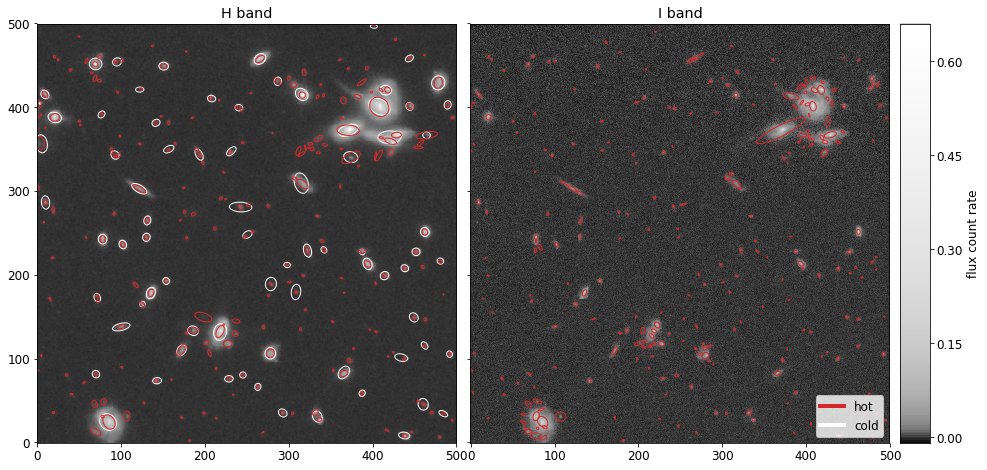

In [79]:
fig = plt.figure(figsize=(16, 12))
grid = ImageGrid(fig, 111, nrows_ncols=(1,2), axes_pad=0.2, share_all=True, cbar_location="right", \
                 cbar_mode="single", cbar_size="7%", cbar_pad=0.15)
images = [image_h, image_i]
imax = np.max([np.max(image) for image in images])
imin = np.min([np.min(image) for image in images])
bids = list(bands.keys())
for (i,ax) in enumerate(grid):
    ax.set_title(bids[i]+" band")
    im = ax.imshow(images[i], interpolation='nearest', cmap='gray', norm=SymLogNorm(linthresh=1e-2), vmin=imin, vmax=imax, origin='lower')
    for o in MMSE.catalog[MMSE.catalog['band'].str.match(bids[i])].itertuples():
        if o.mode == 'cold':
            ec = 'white'
        elif o.mode == 'hot':
            ec = 'C3'
        e = Ellipse(xy=(o.x, o.y), width=2*o.a, height=2*o.b, angle=o.theta*180.0/np.pi, edgecolor=ec, facecolor='none')
        ax.add_artist(e)
#ax.xaxis.set_major_locator(plt.NullLocator())
#ax.yaxis.set_major_locator(plt.NullLocator())
ax.cax.colorbar(im)
ax.cax.toggle_label(True)
cax = grid.cbar_axes[0]
axis = cax.axis[cax.orientation]
axis.label.set_text("flux count rate")
lines = [Line2D([0], [0], color='C3', lw=4),
         Line2D([0], [0], color='white', lw=4)]
ax.legend(lines, ['hot', 'cold'], loc='lower right')
fig.savefig("images/H-I-detections.png", bbox_inches='tight')
fig.savefig("images/H-I-detections.pdf", bbox_inches='tight')

In [11]:
MMSE.catalog[:10]

x           y       cxx       cyy  \
a7f13f93fad08353fe6c7943077f539a  437.770069    8.276103  0.022434  0.063606   
cb5cb473285a3b361de540e6a1c874d9  292.870028   35.132315  0.039321  0.044983   
3bd935a6d55ae23f5540d7e5f5fe7950  334.120633   30.768455  0.030430  0.023494   
be79146e8bb381c080c8f2e86aa88a93  387.599846   58.622513  0.074164  0.072336   
9f19873b35f8a882dedea2c65da46c87  460.412647   45.445571  0.026978  0.020769   
ea7c5dafa74c3db442a9d131b6b82089  484.392646   34.280794  0.047435  0.090997   
029e5b8fe30b79754b7a77ff62462df7  142.961863   73.568286  0.035516  0.072812   
ca4f3be5e09037401b0f2f63ea08d984   84.333246   24.257346  0.010488  0.010507   
aef7b567faae8716f379ca90ace352bb   69.988642   81.362772  0.050346  0.051185   
592e2cc63c3a0ad6e5cc190ac93ac070  491.789503  105.263703  0.083932  0.070671   

                                       cxy          a         b     theta  \
a7f13f93fad08353fe6c7943077f539a  0.012356   6.815604  3.937088 -0.145779   
cb5cb473285a3b361de540e6a1c874d9  0.016994   5.488554  4.423359 -0.624590   
3bd935a6d55ae23f5540d7e5f5fe7950  0.010458   6.952580  5.485192 -1.078212   
be79146e8bb381c080c8f2e86aa88a93 -0.017768   3.943025  3.488305  0.836680   
9f19873b35f8a882dedea2c65da46c87  0.003170   7.003512  6.045720 -1.334810   
ea7c5dafa74c3db442a9d131b6b82089  0.061642   5.636528  3.057713 -0.477796   
029e5b8fe30b79754b7a77ff62462df7 -0.007301   5.332900  3.696978  0.096664   
ca4f3be5e09037401b0f2f63ea08d984  0.003380  10.655880  9.058322 -0.782576   
aef7b567faae8716f379ca90ace352bb  0.007742   4.618960  4.277282 -0.731468   
592e2cc63c3a0ad6e5cc190ac93ac070  0.012209   3.826709  3.403761 -1.198750   

                                  mode band  is_sub main_uid  has_subs  \
a7f13f93fad08353fe6c7943077f539a  cold    H   False     None     False   
cb5cb473285a3b361de540e6a1c874d9  cold    H   False     None     False   
3bd935a6d55ae23f5540d7e5f5fe7950  cold    H   False     None     False   
be79146e8bb381c080c8f2e86aa88a93  cold    H   False     None     False   
9f19873b35f8a882dedea2c65da46c87  cold    H   False     None     False   
ea7c5dafa74c3db442a9d131b6b82089  cold    H   False     None     False   
029e5b8fe30b79754b7a77ff62462df7  cold    H   False     None     False   
ca4f3be5e09037401b0f2f63ea08d984  cold    H   False     None     False   
aef7b567faae8716f379ca90ace352bb  cold    H   False     None     False   
592e2cc63c3a0ad6e5cc190ac93ac070  cold    H   False     None     False   

                                 similar_to  keep  
a7f13f93fad08353fe6c7943077f539a       None  None  
cb5cb473285a3b361de540e6a1c874d9       None  None  
3bd935a6d55ae23f5540d7e5f5fe7950       None  None  
be79146e8bb381c080c8f2e86aa88a93       None  None  
9f19873b35f8a882dedea2c65da46c87       None  None  
ea7c5dafa74c3db442a9d131b6b82089       None  None  
029e5b8fe30b79754b7a77ff62462df7       None  None  
ca4f3be5e09037401b0f2f63ea08d984       None  None  
aef7b567faae8716f379ca90ace352bb       None  None  
592e2cc63c3a0ad6e5cc190ac93ac070       None  None

# Flux cut

We now look into the large and bright objects detected in the H band with SExctractor run in the the _cold_ mode and select the top 20%.

In [12]:
MMSE.set_flux()

In [13]:
MMSE.catalog.iloc[:10, [0,1,-1]]

x           y       flux
a7f13f93fad08353fe6c7943077f539a  437.770069    8.276103   1.396816
cb5cb473285a3b361de540e6a1c874d9  292.870028   35.132315   0.342159
3bd935a6d55ae23f5540d7e5f5fe7950  334.120633   30.768455   2.314875
be79146e8bb381c080c8f2e86aa88a93  387.599846   58.622513   0.241057
9f19873b35f8a882dedea2c65da46c87  460.412647   45.445571   0.407623
ea7c5dafa74c3db442a9d131b6b82089  484.392646   34.280794   0.156279
029e5b8fe30b79754b7a77ff62462df7  142.961863   73.568286   0.533236
ca4f3be5e09037401b0f2f63ea08d984   84.333246   24.257346  24.669451
aef7b567faae8716f379ca90ace352bb   69.988642   81.362772   0.301604
592e2cc63c3a0ad6e5cc190ac93ac070  491.789503  105.263703   0.267795

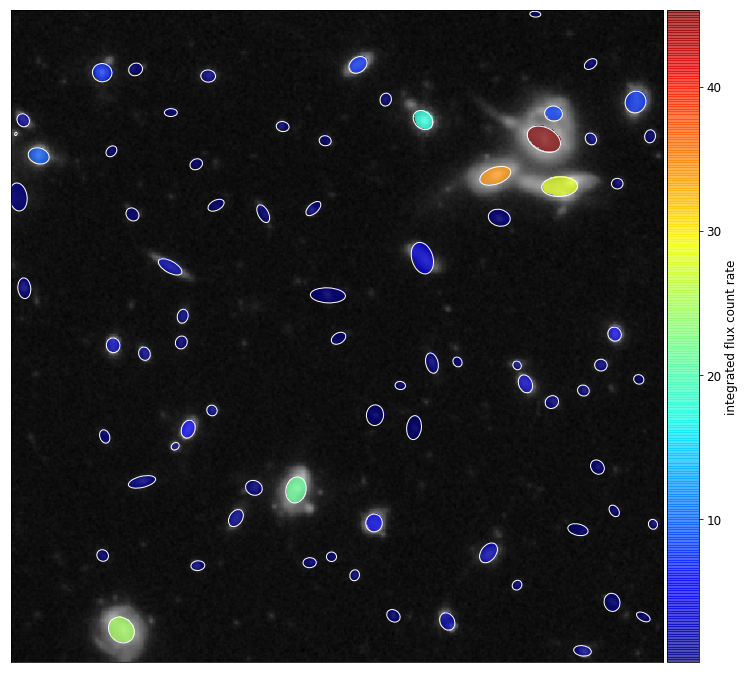

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
ax.imshow(image_h, interpolation='nearest', cmap='gray', norm=SymLogNorm(linthresh=1e-2), origin='lower')
overlay = np.zeros_like(image_h)
fluxes = []
objects = []
pixels = []
for o in MMSE.catalog[MMSE.catalog['band'].str.match('H')].itertuples():
    if o.mode == 'cold':
        p = np.array(list(MMSE._get_ellipse(o)))
        overlay[p[:,0], p[:,1]] = o.flux
        e = Ellipse(xy=(o.x, o.y), width=2*o.a, height=2*o.b, angle=o.theta*180.0/np.pi, edgecolor='white', facecolor='none')
        ax.add_artist(e)
        fluxes.append(o.flux)
        objects.append(o)
        pixels.append(p)
im = ax.imshow(np.ma.masked_where(overlay==0.0, overlay), interpolation='nearest', origin='lower', cmap='jet', alpha=0.7)
ax.xaxis.set_major_locator(plt.NullLocator())
ax.yaxis.set_major_locator(plt.NullLocator())
fig.colorbar(im, cax=cax, orientation='vertical', label="integrated flux count rate")
fig.savefig("images/H-integrated-flux.png", bbox_inches='tight')
fig.savefig("images/H-integrated-flux.pdf", bbox_inches='tight')

Text(0.5,1,'Flux count rate cut')

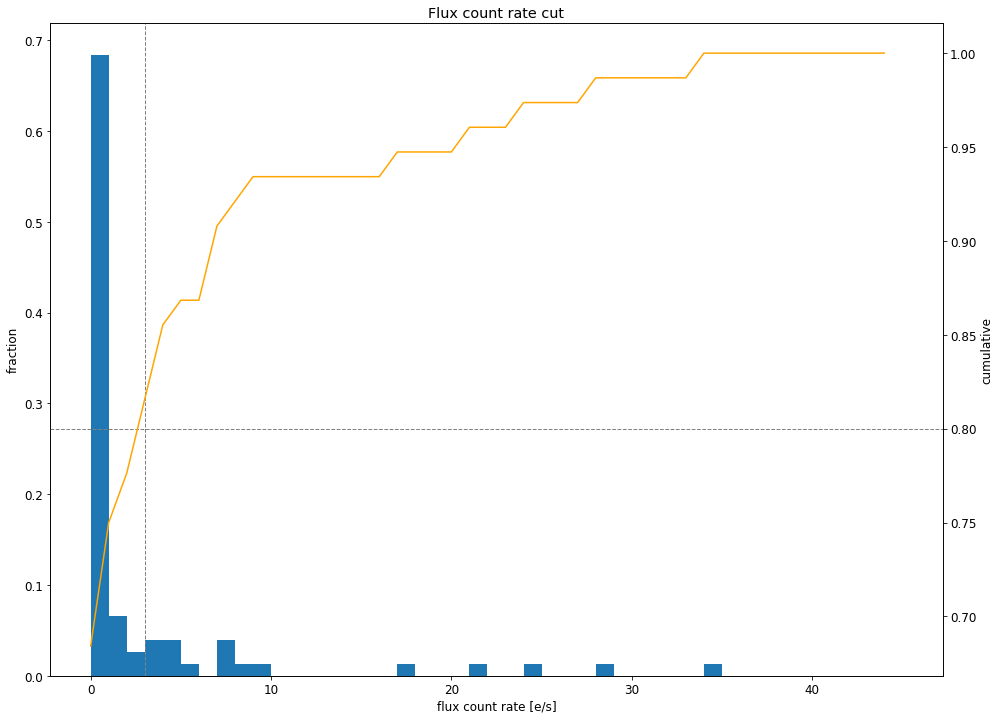

In [15]:
select_top = 0.2
fig, ax1 = plt.subplots(1, 1, figsize=(16, 12))
bins = np.arange(np.floor(np.min(fluxes)),np.ceil(np.max(fluxes)))
hist = ax1.hist(fluxes, bins=bins, density=True)
ax1.set_xlabel("flux count rate [e/s]")
ax1.set_ylabel("fraction")
ax2 = ax1.twinx()
cumulative = np.cumsum(hist[0])
cut = hist[1][np.argmin(np.abs(cumulative-(1.0-select_top)))]
ax2.axhline(y=(1.0-select_top), linewidth=1, linestyle='dashed', color='gray')
ax2.axvline(x=cut, linewidth=1, linestyle='dashed', color='gray')
ax2.plot(hist[1][:-1], cumulative, color='orange')
ax2.set_ylabel("cumulative")
ax1.set_title("Flux count rate cut")

In [16]:
print(cut)

3.0


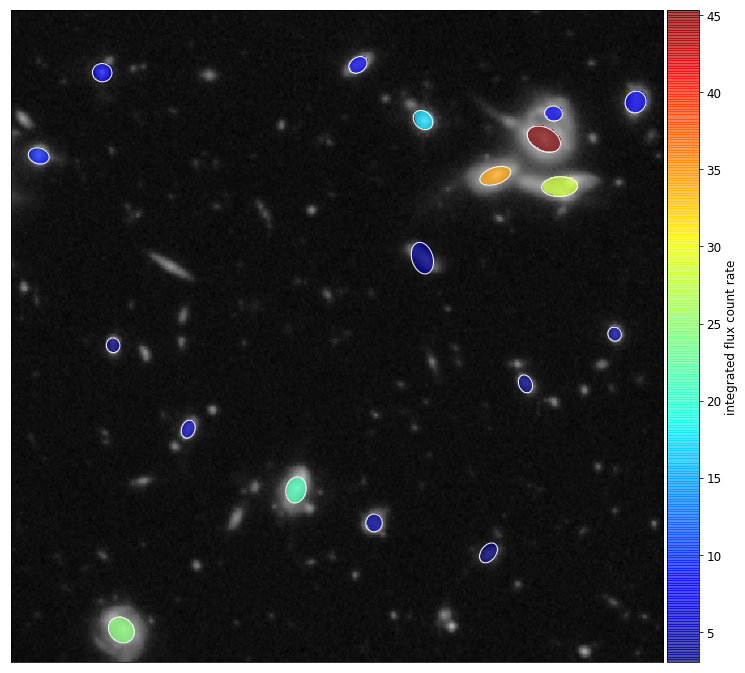

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
ax.imshow(image_h, interpolation='nearest', cmap='gray', norm=SymLogNorm(linthresh=1e-2), origin='lower')
overlay = np.zeros_like(image_h)
selection = np.where(fluxes > cut)[0]
fluxes_selection = []
objects_selection = []
pixels_selection = []
for i in selection:
    fluxes_selection.append(fluxes[i])
    objects_selection.append(objects[i])
    pixels_selection.append(pixels[i])
for (f,o,p) in zip(fluxes_selection, objects_selection, pixels_selection):
    overlay[p[:,0], p[:,1]] = f
    e = Ellipse(xy=(o.x, o.y), width=2*o.a, height=2*o.b, angle=o.theta*180.0/np.pi, edgecolor='white', facecolor='none')
    ax.add_artist(e)
im = ax.imshow(np.ma.masked_where(overlay==0.0, overlay), interpolation='nearest', origin='lower', cmap='jet', alpha=0.7)
fig.colorbar(im, cax=cax, orientation='vertical', label="integrated flux count rate")
#ax.set_title("Top {:.1f}% flux cut selection".format(select_top*100))
ax.xaxis.set_major_locator(plt.NullLocator())
ax.yaxis.set_major_locator(plt.NullLocator())
fig.savefig("images/H-flux-selection.png", bbox_inches='tight')
fig.savefig("images/H-flux-selection.pdf", bbox_inches='tight')

# Sub-structure detection

For the objects selected above we look at the structure detected in the I band with SExtractor run in the _hot_ mode.

## I band sub-structures

In [18]:
MMSE.find_substructures('H', 'cold', 'I', 'hot', percentile=0.2)

Looking for substructures in sources with flux count rate >= 3.05
- substructures for source ca4f3be5e09037401b0f2f63ea08d984
	 + e6ce6bb06395b1f89bbf83ea24bdb5d2
	 + 80e6f2b209bee0191ff898a1adc387d7
	 + d2cbf91f1ce52ff71b3c9316204d4214
	 + 5b9b2caca568b2b34c28f287248f3acb
	 + f9a46ac0e29c6012c95d39a71449b689
	 + 9971f666995cb1f20f5b9a4573471697
- substructures for source 52c418d89c8ceb3f715cbcd0a255daff
	 + aa70ee9a6eb87ad83778ff410cd84632
	 + 3b99948ad88c5d9eb79b9c686c769ad6
	 + 55b467220e9e21dfb2fb05fe5ebc1264
	 + d1d01493f27c011dc9b768541d7d1f4d
	 + 221a42b808504afec3a582baacf36d70
	 + d0fea9ca6062b7693890babf5a6e4756
	 + 64a265f3821a4b73fba48d4f063c7b13
	 + 331528e0d40e297df5bc29a89191589d
- substructures for source e7367923ae40011858736a3e2fea3e8a
	 + 8347878cb4ae535dd486a45a38e3275b
	 + 19af1b2958f1b87610ce3a562b528adf
	 + 8b08f85738ae5b021f4b5c7471f7fc1c
	 + bcd0b20e452f4aa0e0c785495af4c843
	 + cd42a41b4d215f398ab4e7aa245da502
	 + dcad57d3932f83bd17f23987cae9be4c
	 + 45f7abbd19

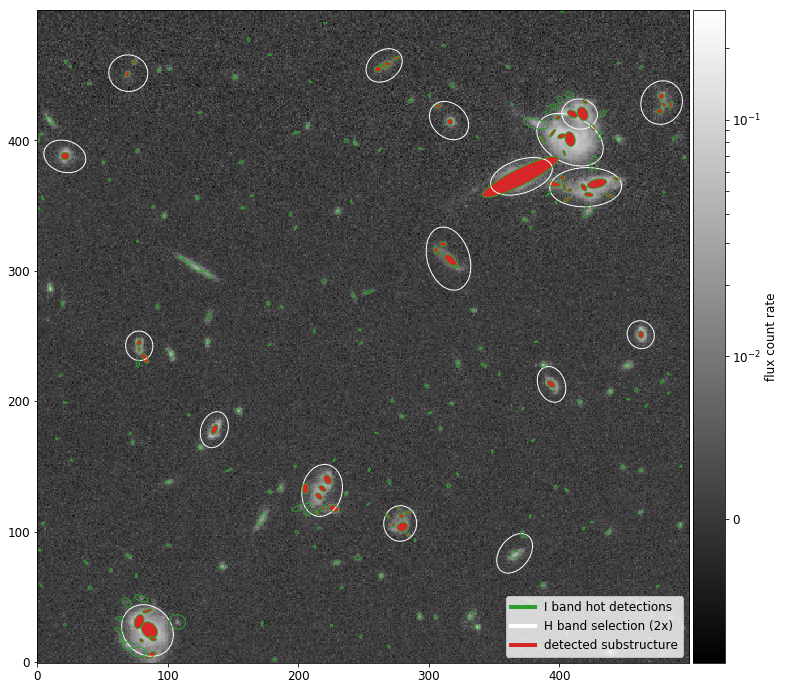

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(image_i, interpolation='nearest', cmap='gray', norm=SymLogNorm(linthresh=1e-2), origin='lower')
for o in objects_selection:
    substructures = MMSE.catalog[MMSE.catalog['band'].str.match('I') & MMSE.catalog['main_uid'].str.match(o.Index)]
    for s in substructures.itertuples():
        e = Ellipse(xy=(s.x, s.y), width=2*s.a, height=2*s.b, angle=s.theta*180.0/np.pi, edgecolor='none', facecolor='C3')
        ax.add_artist(e)
    e = Ellipse(xy=(o.x, o.y), width=4*o.a, height=4*o.b, angle=o.theta*180.0/np.pi, edgecolor='white', facecolor='none')
    ax.add_artist(e)
for o in MMSE.catalog[MMSE.catalog['band'].str.match('I')].itertuples():
    e = Ellipse(xy=(o.x, o.y), width=2*o.a, height=2*o.b, angle=o.theta*180.0/np.pi, edgecolor='C2', facecolor='none')
    ax.add_artist(e)
#ax.set_title("Sub-structure detection in the I band")
fig.colorbar(im, cax=cax, orientation='vertical', label="flux count rate")
lines = [Line2D([0], [0], color='C2', lw=4),
         Line2D([0], [0], color='white', lw=4),
         Line2D([0], [0], color='C3', lw=4)]
ax.legend(lines, ['I band hot detections', 'H band selection (2x)', 'detected substructure'], loc='lower right')
fig.savefig("images/I-band-substructure.png", bbox_inches='tight')
fig.savefig("images/I-band-substructure.pdf", bbox_inches='tight')

In [20]:
MMSE.catalog.loc[MMSE.catalog['is_sub'] & MMSE.catalog['band'].str.match('I'), ['x', 'y', 'is_sub', 'main_uid']]

x           y  is_sub  \
e6ce6bb06395b1f89bbf83ea24bdb5d2   88.372527   18.043776    True   
80e6f2b209bee0191ff898a1adc387d7   85.772560   24.553009    True   
d2cbf91f1ce52ff71b3c9316204d4214   77.946842   31.144634    True   
5b9b2caca568b2b34c28f287248f3acb   79.693440   16.665223    True   
f9a46ac0e29c6012c95d39a71449b689   84.234506   39.244319    True   
9971f666995cb1f20f5b9a4573471697   87.013016    5.514684    True   
8347878cb4ae535dd486a45a38e3275b  272.687926  105.131452    True   
19af1b2958f1b87610ce3a562b528adf  279.746945  103.713959    True   
8b08f85738ae5b021f4b5c7471f7fc1c  278.926428  112.223116    True   
bcd0b20e452f4aa0e0c785495af4c843  284.228665  114.793822    True   
cd42a41b4d215f398ab4e7aa245da502  284.287825   97.412800    True   
dcad57d3932f83bd17f23987cae9be4c  277.343813  117.326391    True   
45f7abbd19d30f6ccd21fc9d775dd9a1  268.182283  111.930214    True   
aa70ee9a6eb87ad83778ff410cd84632  215.793266  127.063372    True   
3b99948ad88c5d9eb79b9c686c769ad6  218.519539  132.994428    True   
55b467220e9e21dfb2fb05fe5ebc1264  222.404362  139.998510    True   
d1d01493f27c011dc9b768541d7d1f4d  218.991591  117.985800    True   
221a42b808504afec3a582baacf36d70  227.271218  117.754822    True   
d0fea9ca6062b7693890babf5a6e4756  214.008529  116.000000    True   
64a265f3821a4b73fba48d4f063c7b13  213.999043  114.000000    True   
331528e0d40e297df5bc29a89191589d  205.359027  133.194794    True   
d7e202f050dfc3f98f4997f29b11ec4a  135.705787  178.347168    True   
98565ec61068b145724705551d856300  396.477430  207.532843    True   
0f71cf644cea247f4abdae5452f3f525  393.644449  213.234066    True   
efe7f7ba4d1f5834bb9c611c877eb722   78.000000  240.005801    True   
eeb7ab9bead0b5f0d04428412e827015   77.917574  244.879106    True   
7a05d8265dd91ef5dd307b7a50b7c531   82.514597  232.971513    True   
b53cef3a8978f5c2bdd4004eb60792b2  462.554415  251.042404    True   
dd07021658c0a7e924fdd10fe18c82c7  321.016776  303.000000    True   
3820c1d01192ce610b2a9a29f84009aa  316.583141  308.203514    True   
...                                      ...         ...     ...   
5b12228acefe8eb58c2c7d2a38813a8c  408.193395  400.928396    True   
ab79479e9e4558b4bd3b9cc5d67b72ee  394.793106  405.399938    True   
c9557bb64fdfe23aad3c0b5fe32df1b5  422.575269  358.281479    True   
9efa873ceaacdc8f07801303835ec1a7  418.791053  363.898042    True   
b3e5312bc6b199974811dc1568051fb6  410.050038  420.174997    True   
09a9ba85c03b87d54b83e5b3cde5e799  417.933891  420.402619    True   
6c6425df76bed97563968018906de8a6  403.750755  390.243894    True   
8a0550804c0dedf34471610197c58c17  428.864290  366.858923    True   
8964712d008417b77801c708290d77ac  425.509933  409.983075    True   
c7f51afe2ab6a26699005b98a8f3455b  399.016553  417.519699    True   
9449260fb60d2f266f63f2afff9a2030  407.983875  361.776218    True   
72caadb0c15d8540b1fee77c24e37bb5  419.676984  429.660709    True   
c7d1d4023ce79ccfb20aa249d94b35ca  443.762690  370.391611    True   
037dee853a2f43342dbeeea373e7225f  403.744568  364.458357    True   
456fa2396b8ef27b3361705a71f4c167  395.866672  366.351864    True   
86bfd70ee1e86efea9635aebae98e570  386.821924  400.398793    True   
bb202541de44c662d47a0d5645682a42  370.090944  371.912597    True   
f8f5214375b469da439edef6f29cadef  438.237942  357.754457    True   
9b5de4758882b94a4e54c63454f9ec18  402.254983  371.287223    True   
39f93214ab05dcb541b336a705f7c682  406.062393  354.538194    True   
bd9606f881a53f3ede461dc079eaa5a7  477.028981  422.273783    True   
c61d55c8068f39aeb552d35db559a0d4  479.998184  427.396979    True   
f7a35cdbe2842240d0108682fe03b257  478.280943  433.796058    True   
1280442292e5ec7a00711c4ca5cc582e  485.661920  427.158006    True   
c0475b88f5cfc5f5c16f6a445558df29   68.893905  450.496316    True   
570e137bbcb1ebdc952bbeffbb5f1246   74.327005  460.024015    True   
18fdb466e7fb3d9d3d844fc54c0f8831  265.456487  456.777522    True   
070dc824c940113cabf404fc53cc2e1

## H band sub-structrures

In [21]:
MMSE.find_substructures('H', 'cold', 'H', 'hot', percentile=0.2)

Looking for substructures in sources with flux count rate >= 3.05
- substructures for source ca4f3be5e09037401b0f2f63ea08d984
	 + 054a976053cfcb5ddc28a9aad62d546f
	 + ab6c630c7313cc0a932c75bcb67a34e3
- substructures for source 52c418d89c8ceb3f715cbcd0a255daff
	 + c08046f723a44efd4c21ab36491e6dc4
	 + a0d57c8fc949d262daa4d2f0501475f3
	 + 43355bc3ac59dea6a499e7e870324526
- substructures for source e7367923ae40011858736a3e2fea3e8a
	 + 2a853b28575ecaf33e973964c05f685c
- substructures for source a2b86156ca9104387d1576be014b84d7
	 + b4d1a4f915b9b5393c73f4e0eccd7831
- substructures for source f60c9def0bc47eb24c093ef8037eeea7
	 + ff564a2d3b81cb35c043980a055e523c
- substructures for source a2e7875af1b0dabcfb68a8009b592385
	 + 67ed4c7ede07e8ef33864740134f833e
- substructures for source 193e30b9b8aebccba2cf32c664a98484
	 + 49c738c1c20426496ebf83f605979af9
- substructures for source 21e40a522367288240ca6f2a998eb71d
	 + c5ad750c1d5880983dfd7ae6314f65a2
- substructures for source ba9343a891034deceb27

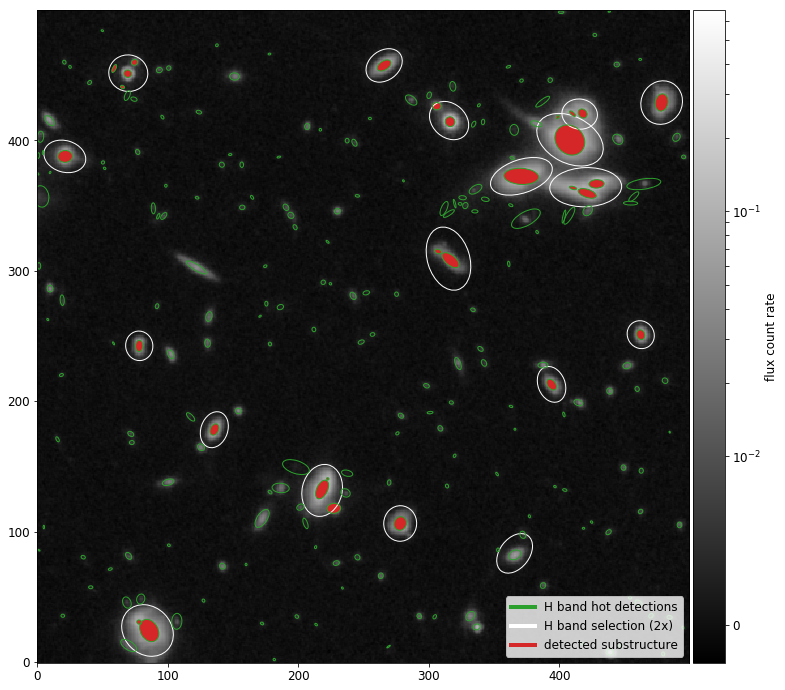

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(image_h, interpolation='nearest', cmap='gray', norm=SymLogNorm(linthresh=1e-2), origin='lower')
for o in objects_selection:
    substructures = MMSE.catalog[MMSE.catalog['band'].str.match('H') & MMSE.catalog['mode'].str.match('hot') & MMSE.catalog['main_uid'].str.match(o.Index)]
    for s in substructures.itertuples():
        e = Ellipse(xy=(s.x, s.y), width=2*s.a, height=2*s.b, angle=s.theta*180.0/np.pi, edgecolor='none', facecolor='C3')
        ax.add_artist(e)
    e = Ellipse(xy=(o.x, o.y), width=4*o.a, height=4*o.b, angle=o.theta*180.0/np.pi, edgecolor='white', facecolor='none')
    ax.add_artist(e)
for o in MMSE.catalog[MMSE.catalog['band'].str.match('H') & MMSE.catalog['mode'].str.match('hot')].itertuples():
    e = Ellipse(xy=(o.x, o.y), width=2*o.a, height=2*o.b, angle=o.theta*180.0/np.pi, edgecolor='C2', facecolor='none')
    ax.add_artist(e)
#ax.set_title("Sub-structure detection in the H band")
fig.colorbar(im, cax=cax, orientation='vertical', label="flux count rate")
lines = [Line2D([0], [0], color='C2', lw=4),
         Line2D([0], [0], color='white', lw=4),
         Line2D([0], [0], color='C3', lw=4)]
ax.legend(lines, ['H band hot detections', 'H band selection (2x)', 'detected substructure'], loc='lower right')
fig.savefig("images/H-band-substructure.png", bbox_inches='tight')
fig.savefig("images/H-band-substructure.pdf", bbox_inches='tight')

In [23]:
MMSE.catalog.loc[MMSE.catalog['is_sub'] & MMSE.catalog['band'].str.match('H') & MMSE.catalog['mode'].str.match('hot'), ['x', 'y', 'is_sub', 'main_uid']]

x           y  is_sub  \
054a976053cfcb5ddc28a9aad62d546f   85.652888   24.246656    True   
ab6c630c7313cc0a932c75bcb67a34e3   77.997057   30.709530    True   
2a853b28575ecaf33e973964c05f685c  278.025007  106.276665    True   
c08046f723a44efd4c21ab36491e6dc4  218.134067  132.322928    True   
a0d57c8fc949d262daa4d2f0501475f3  222.507885  140.499816    True   
43355bc3ac59dea6a499e7e870324526  227.131026  117.881176    True   
b4d1a4f915b9b5393c73f4e0eccd7831  135.662395  178.312449    True   
ff564a2d3b81cb35c043980a055e523c  394.084112  212.739194    True   
49c738c1c20426496ebf83f605979af9   77.968374  242.389849    True   
67ed4c7ede07e8ef33864740134f833e  462.403248  251.001228    True   
95d4eac28d6faa0d914b507d3b05f0aa  316.584594  308.112230    True   
597191ac6f6ed68b21ce2e748f57976a  307.110340  314.773597    True   
c5ad750c1d5880983dfd7ae6314f65a2   21.183457  387.648026    True   
48441e0e78a4ef5ed6bd1ececa6a8313  421.411772  359.280515    True   
a2cf9081b1a33c8345b5c726554798e7  428.531130  366.591344    True   
78b81ca741712b19ec15059462ac8a9b  410.503149  363.497416    True   
3ff57779a70e21bea0e4cd43c3d0c948  410.131532  420.376400    True   
fc91fcfd4f879982eb2f13055ad40680  417.888118  420.545257    True   
9d0050157ee5d9075ec8331abd8a8bab  408.041159  400.212203    True   
fd2b0f89bb850f13ae753d54e26fb179  398.840653  417.828785    True   
bcbf99df8bf5ed866bad12d9ca1a7b85  370.801728  372.347963    True   
84dadfb88c7c2f61578af16a166194cb  316.247436  414.265082    True   
d3911d13d7ca8c788ecf04907594c2b4  306.050493  426.213996    True   
63df3a9ff708c1d0921a3dfdee80e5d8  478.412632  428.979876    True   
d88f05c236c83bfab94ff2b0d1690ed9   69.185126  451.053554    True   
8494f1d12d70edffd1f5a09699705fd2   74.403840  459.721819    True   
56a7032ee2f5942e181b6717f7c6da60   65.182905  440.815724    True   
79927805453e3b1391e355896e01cddb   58.814027  455.025907    True   
682c62959230f04258364237b80336f5  265.714200  457.376660    True   

                                                          main_uid  
054a976053cfcb5ddc28a9aad62d546f  ca4f3be5e09037401b0f2f63ea08d984  
ab6c630c7313cc0a932c75bcb67a34e3  ca4f3be5e09037401b0f2f63ea08d984  
2a853b28575ecaf33e973964c05f685c  e7367923ae40011858736a3e2fea3e8a  
c08046f723a44efd4c21ab36491e6dc4  52c418d89c8ceb3f715cbcd0a255daff  
a0d57c8fc949d262daa4d2f0501475f3  52c418d89c8ceb3f715cbcd0a255daff  
43355bc3ac59dea6a499e7e870324526  52c418d89c8ceb3f715cbcd0a255daff  
b4d1a4f915b9b5393c73f4e0eccd7831  a2b86156ca9104387d1576be014b84d7  
ff564a2d3b81cb35c043980a055e523c  f60c9def0bc47eb24c093ef8037eeea7  
49c738c1c20426496ebf83f605979af9  193e30b9b8aebccba2cf32c664a98484  
67ed4c7ede07e8ef33864740134f833e  a2e7875af1b0dabcfb68a8009b592385  
95d4eac28d6faa0d914b507d3b05f0aa  66dcd324da08327bc509b6719eb06ff6  
597191ac6f6ed68b21ce2e748f57976a  66dcd324da08327bc509b6719eb06ff6  
c5ad750c1d5880983dfd7ae6314f65a2  21e40a522367288240ca6f2a998eb71d  
48441e0e78a4ef5ed6bd1ececa6a8313  ba67f8e8561e700a74367ac3319adfec  
a2cf9081b1a33c8345b5c726554798e7  ba67f8e8561e700a74367ac3319adfec  
78b81ca741712b19ec15059462ac8a9b  ba67f8e8561e700a74367ac3319adfec  
3ff57779a70e21bea0e4cd43c3d0c948  fba6da1a68ad36bf5eec71738e23bf1e  
fc91fcfd4f879982eb2f13055ad40680  fba6da1a68ad36bf5eec71738e23bf1e  
9d0050157ee5d9075ec8331abd8a8bab  bc88882a2d3e96732345f82837d31b19  
fd2b0f89bb850f13ae753d54e26fb179  bc88882a2d3e96732345f82837d31b19  
bcbf99df8bf5ed866bad12d9ca1a7b85  df2c0c9335b4d0151c62e0f9eb0c4d2e  
84dadfb88c7c2f61578af16a166194cb  47a726947a2fca1f7b31b25878200e0a  
d3911d13d7ca8c788ecf04907594c2b4  47a726947a2fca1f7b31b25878200e0a  
63df3a9ff708c1d0921a3dfdee80e5d8  27decd99677af2c1a3cad812487f38f2  
d88f05c236c83bfab94ff2b0d1690ed9  ba9343a891034deceb27844871602cae  
8494f1d12d70edffd1f5a09699705fd2  ba9343a891034deceb27844871602cae  
56a7032ee2f5942e181b6717f7c6da60  ba9343a891034deceb27844871602cae  
79927805453e3b1391e355896e01cddb  ba9343a891034deceb27844871602cae  
6

## H vs I band sub-structures

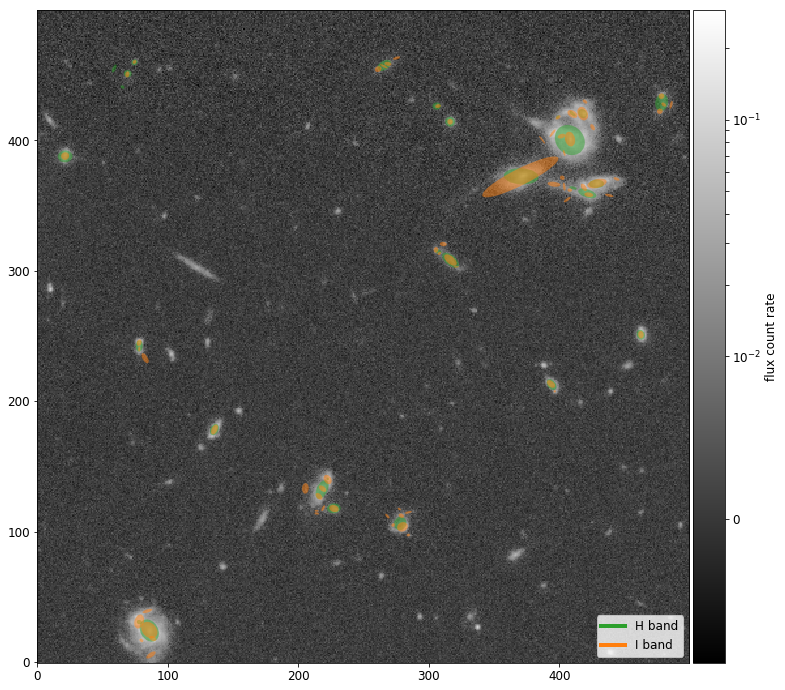

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(image_i, interpolation='nearest', cmap='gray', norm=SymLogNorm(linthresh=1e-2), origin='lower')
for o in MMSE.catalog[MMSE.catalog['is_sub'] & MMSE.catalog['band'].str.match('H') & MMSE.catalog['mode'].str.match('hot')].itertuples():
    e = Ellipse(xy=(o.x, o.y), width=2*o.a, height=2*o.b, angle=o.theta*180.0/np.pi, edgecolor='none', facecolor='C2', alpha=0.5)
    ax.add_artist(e)
for o in MMSE.catalog[MMSE.catalog['is_sub'] & MMSE.catalog['band'].str.match('I') & MMSE.catalog['mode'].str.match('hot')].itertuples():
    e = Ellipse(xy=(o.x, o.y), width=2*o.a, height=2*o.b, angle=o.theta*180.0/np.pi, edgecolor='none', facecolor='C1', alpha=0.5)
    ax.add_artist(e)
#ax.set_title("H vs I band sub-structures")
fig.colorbar(im, cax=cax, orientation='vertical', label="flux count rate")
lines = [Line2D([0], [0], color='C2', lw=4),
         Line2D([0], [0], color='C1', lw=4)]
ax.legend(lines, ['H band', 'I band'], loc='lower right')
fig.savefig("images/H-vs-I-substructure.png", bbox_inches='tight')
fig.savefig("images/H-vs-I-substructure.pdf", bbox_inches='tight')

## Compare cold and hot modes in H band

In [25]:
MMSE.find_similar('H', 'cold', 'hot', threshold=10.0)

In [26]:
MMSE.catalog.loc[MMSE.catalog['similar_to'].notnull() & MMSE.catalog['band'].str.match('H') & MMSE.catalog['mode'].str.match('hot'), ['x', 'y', 'a', 'b', 'theta', 'band', 'mode', 'similar_to']]

x           y          a         b  \
a466a06a8cc5f7b9be9cb76f5a920a73  387.510703   58.747777   2.265723  1.962873   
13cd6b6f6e4ded1ea6eb75a6c18e1ae6  492.083020  105.185472   2.155965  1.732348   
d0fd54e05f015ebcc84a65d1b3b6265e  172.174945  110.171249   7.886893  3.821144   
e584729f1267a3b2c66aa2c458477c96  125.358429  164.747142   2.885869  2.283019   
a32b4d208131a7bda0ef1a12094d9452  298.167198  211.859984   2.253084  1.590980   
6bf570e5d9d20c0ee51cd751bb274621  387.411274  227.668181   3.793326  2.118646   
85ef4f415e4a32485b7c0617976448a4  342.249308  229.328093   2.690161  1.815967   
bcbf99df8bf5ed866bad12d9ca1a7b85  370.801728  372.347963  13.356230  6.182662   
8c7d567dd01e3872412be718b651f6fb  444.779705  400.764525   4.344124  3.396589   
fc0ec6259c242fbc5ac9361e36e96114  286.431191  430.830551   5.114315  2.907909   
e793fb114f8ea33461283f2317df5620  401.324006  498.157080   2.064445  0.974960   

                                     theta band mode  \
a466a06a8cc5f7b9be9cb76f5a920a73  1.053791    H  hot   
13cd6b6f6e4ded1ea6eb75a6c18e1ae6 -1.544592    H  hot   
d0fd54e05f015ebcc84a65d1b3b6265e  0.983516    H  hot   
e584729f1267a3b2c66aa2c458477c96 -0.702264    H  hot   
a32b4d208131a7bda0ef1a12094d9452 -0.385108    H  hot   
6bf570e5d9d20c0ee51cd751bb274621  0.044556    H  hot   
85ef4f415e4a32485b7c0617976448a4 -1.075566    H  hot   
bcbf99df8bf5ed866bad12d9ca1a7b85 -0.053689    H  hot   
8c7d567dd01e3872412be718b651f6fb -0.798538    H  hot   
fc0ec6259c242fbc5ac9361e36e96114 -0.677370    H  hot   
e793fb114f8ea33461283f2317df5620 -0.033448    H  hot   

                                                        similar_to  
a466a06a8cc5f7b9be9cb76f5a920a73  be79146e8bb381c080c8f2e86aa88a93  
13cd6b6f6e4ded1ea6eb75a6c18e1ae6  592e2cc63c3a0ad6e5cc190ac93ac070  
d0fd54e05f015ebcc84a65d1b3b6265e  c1399551118cad1846dc4bd54586d1cd  
e584729f1267a3b2c66aa2c458477c96  8d755816e79b0ac3afac4ac8ee97469f  
a32b4d208131a7bda0ef1a12094d9452  5a43df68cd76f24dc6721921265a1288  
6bf570e5d9d20c0ee51cd751bb274621  0622bfead91cd13a823c1f60f7f2eea1  
85ef4f415e4a32485b7c0617976448a4  7f171dcec81b08a4a35ed44114daa04a  
bcbf99df8bf5ed866bad12d9ca1a7b85  df2c0c9335b4d0151c62e0f9eb0c4d2e  
8c7d567dd01e3872412be718b651f6fb  9378b2254fa6c8ea2b2b01a0bf7dfe6c  
fc0ec6259c242fbc5ac9361e36e96114  b6b1b47dfee5670d85a26c954f310169  
e793fb114f8ea33461283f2317df5620  b44028dddcc31cc40f6bcd18e18ba901

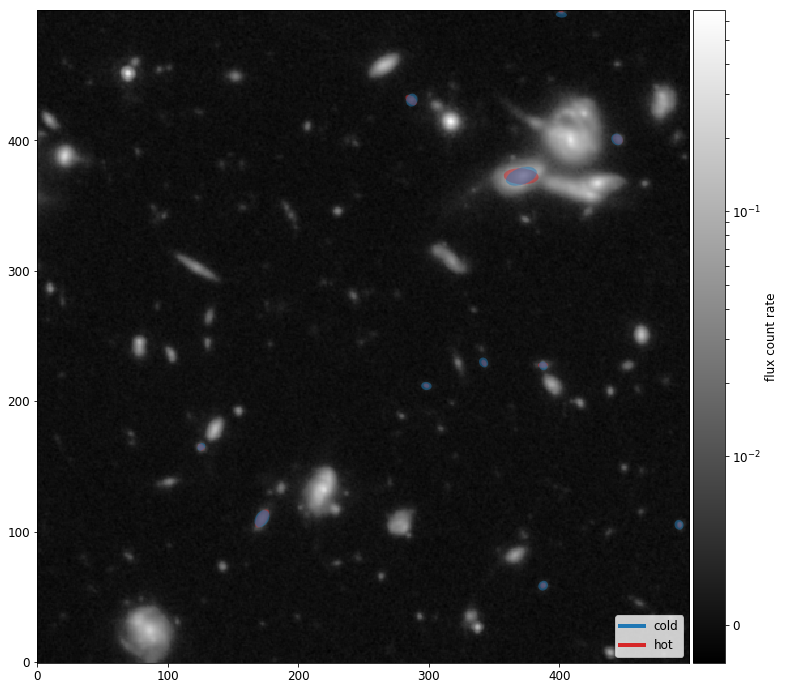

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(image_h, interpolation='nearest', cmap='gray', norm=SymLogNorm(linthresh=1e-2), origin='lower')
for o in MMSE.catalog[MMSE.catalog['similar_to'].notnull() & MMSE.catalog['band'].str.match('H') & MMSE.catalog['mode'].str.match('hot')].itertuples():
    e = Ellipse(xy=(o.x, o.y), width=2*o.a, height=2*o.b, angle=o.theta*180.0/np.pi, edgecolor='none', facecolor='C3', alpha=0.5)
    ax.add_artist(e)
    s = MMSE.catalog.loc[o.similar_to]
    f = Ellipse(xy=(s.x, s.y), width=2*s.a, height=2*s.b, angle=s.theta*180.0/np.pi, edgecolor='none', facecolor='C0', alpha=0.5)
    ax.add_artist(f)
#ax.set_title("Similar sub-structures in H band")
fig.colorbar(im, cax=cax, orientation='vertical', label="flux count rate")
lines = [Line2D([0], [0], color='C0', lw=4),
         Line2D([0], [0], color='C3', lw=4)]
ax.legend(lines, ['cold', 'hot'], loc='lower right')
fig.savefig("images/H-band-hot-cold-similar.png", bbox_inches='tight')
fig.savefig("images/H-band-hot-cold-similar.pdf", bbox_inches='tight')

## Compare hot modes across H and I bands

In [28]:
MMSE.find_similar('H', 'hot', 'hot', band2='I', threshold=10.0)

In [29]:
MMSE.catalog.loc[MMSE.catalog['similar_to'].notnull() & MMSE.catalog['band'].str.match('I') & MMSE.catalog['mode'].str.match('hot'), ['x', 'y', 'a', 'b', 'theta', 'band', 'mode', 'similar_to']]

x           y         a         b  \
7ff7e1d2c963165e628aff254be77781  181.632241    2.179122  1.311644  0.904572   
43382e8c72f822eaf81512063b50cc52  479.348026    6.109480  1.141883  0.919788   
4982f62e2bf71e717a451648ad7d9592  438.903798    7.723834  1.999444  1.596123   
9088ee2ff6bfb42ac509c3147d66fbba  269.400586   11.851917  1.309684  0.409706   
0e348acf7cd54d4c4f933524eabe9a01  494.468763   26.360101  0.965801  0.802499   
17a7a5789c3a799817599da25962b80c   20.906663   28.882095  0.876633  0.741365   
ba8ecccd59712e76852cd8373206c3cb  172.156458   29.485181  1.553118  0.580813   
352001b479cbc380ada4b17d2fa47eb4  304.939915   34.585808  1.266253  1.084087   
f589b3b13c569c37e68e4b6a2009f599  470.808454   35.253803  1.700153  0.543740   
5e1f709a39e1d94e92b5404d24871293  484.873779   34.468662  1.296169  0.891240   
02955868c0cf93396ce3e3b6e447e5bb  292.720287   35.051461  1.435485  1.175434   
d6adab0d4a3a5cd3cd28fb179c92f784  336.903361   26.934965  1.558447  1.358796   
f252ccf33fc0faecffd0d49881c39d4e  332.031782   35.597006  3.411889  2.188291   
c2f1bf5e77aa688b7875be6c2c4ac855  461.468428   44.983307  2.481463  1.025022   
321f045f1191309d9508b77ed7b22224   79.496046   48.947205  5.501862  2.136971   
66bc65ce19fda2ad2c301405ebcb3548   68.462572   45.814590  4.272220  2.738239   
0261d151a103138d9216e53e34907e0a  232.882716   57.134460  1.127710  0.550532   
bfe2654992264c0b8d5132eba677ca1c   40.020507   56.931185  1.215881  1.086686   
606e44e3e045f466bcf42fc791e9c406  387.519908   59.296917  1.715980  1.400238   
c8a1146d38140bb14bae572296a4c971  263.176421   66.387767  1.645413  1.237986   
33453108dd1ed3f050290e483016bab7   56.404198   70.377457  1.280411  0.894463   
a81feca2bbb79cae4cab7f0123d442fc   37.268289   76.327864  1.835077  0.659355   
b83b1f688b9d37c10dc8ad1c63788d84  141.566244   73.395166  1.884966  1.698334   
4fffbbced7aa1df8258edc47f71321ca  229.213438   76.190346  2.214637  1.299482   
581ba301ece59780181addfa1a5d29c7   70.085772   81.153627  1.982082  1.020623   
b818d068b9552d7ef87d3c157f8be3c7    1.565554   85.703226  0.966751  0.325847   
d65fcfca20d8013497a43925e9812c6f  245.442678   79.942308  2.231230  1.676637   
6a114bc4ef9ff959f941c9bef544f870  212.517452   88.413994  1.076904  0.765981   
90e0a0fe50175154b5f9285e8546c7a5  366.040032   82.372831  3.635803  2.178862   
dab1e590a28f9c3e1c07a8cabc9fae7e  100.611894   89.576648  1.416326  0.797165   
...                                      ...         ...       ...       ...   
68810bbe6b4109e6aec7f9d9a8e5d494   76.601407  391.887866  1.330578  1.002998   
ee7e1bef84b201de6e9919438e5307cf  236.525628  399.484512  1.395072  1.075670   
a06bb7d3decc324a32c25de35c17e160  243.450036  398.240271  2.215536  1.098138   
9dc719a668fc689d6bc3349c2abf3ecd  488.499806  402.055700  2.267060  1.036129   
0e18fedf67ad6e08c5e1520a1fbcdd21  206.808844  410.767731  1.576244  1.125490   
2b42e8345c97df9802dd8bc23eaf1521  124.270136  421.102668  1.216807  0.515032   
f3f7ddb954eacadeaab3e72b07d17709    9.510382  415.138445  4.062315  1.536032   
422ba2f6025020b652d8632397b5c860  307.037893  426.217619  2.199780  1.439012   
b3e5312bc6b199974811dc1568051fb6  410.050038  420.174997  4.167282  2.556474   
09a9ba85c03b87d54b83e5b3cde5e799  417.933891  420.402619  5.399651  3.855811   
8a0550804c0dedf34471610197c58c17  428.864290  366.858923  7.530097  3.360792   
c7f51afe2ab6a26699005b98a8f3455b  399.016553  417.519699  2.183509  1.224488   
9449260fb60d2f266f63f2afff9a2030  407.983875  361.776218  1.740013  1.300092   
037dee853a2f43342dbeeea373e7225f  403.744568  364.458357  3.056134  0.968879   
658ccea04ffb23adc96925b76d9b93c1  421.677325  345.318418  5.209478  3.021844   
a518ed707c6535fd600d1262bdc243e8  300.380267  434.170428  1.173412  0.462956   
3dd3f28006b701697d58ab296436ab64   39.624896  443.314396  1.181635  0.702419   
203e48bb3e1053191235ebd9c2fc74de  318.208231  441.751509  2.019144  1.361549   
c0475b88f5cfc5f5c16f6a445558df29   68.89390

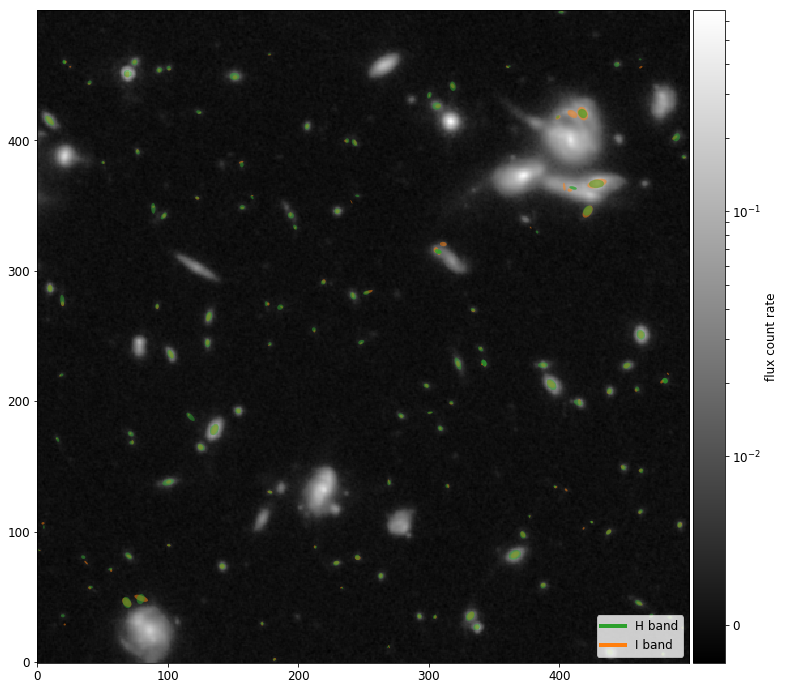

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(image_h, interpolation='nearest', cmap='gray', norm=SymLogNorm(linthresh=1e-2), origin='lower')
for o in MMSE.catalog[MMSE.catalog['similar_to'].notnull() & MMSE.catalog['band'].str.match('I') & MMSE.catalog['mode'].str.match('hot')].itertuples():
    e = Ellipse(xy=(o.x, o.y), width=2*o.a, height=2*o.b, angle=o.theta*180.0/np.pi, edgecolor='none', facecolor='C1', alpha=0.5)
    ax.add_artist(e)
    s = MMSE.catalog.loc[o.similar_to]
    f = Ellipse(xy=(s.x, s.y), width=2*s.a, height=2*s.b, angle=s.theta*180.0/np.pi, edgecolor='none', facecolor='C2', alpha=0.5)
    ax.add_artist(f)
#ax.set_title("Similar sub-structures in hot modes across H and I bands")
fig.colorbar(im, cax=cax, orientation='vertical', label="flux count rate")
lines = [Line2D([0], [0], color='C2', lw=4),
         Line2D([0], [0], color='C1', lw=4)]
ax.legend(lines, ['H band', 'I band'], loc='lower right')
fig.savefig("images/H-I-band-hot-hot-similar.png", bbox_inches='tight')
fig.savefig("images/H-I-band-hot-hot-similar.pdf", bbox_inches='tight')

# Merge detections

## Replace sub-structures in H band with those detected in the I band

In [31]:
subs_h = MMSE.catalog[MMSE.catalog['is_sub'] & MMSE.catalog['band'].str.match('H') & MMSE.catalog['mode'].str.match('hot')]
MMSE.discard(subs_h.index)

In [32]:
MMSE.catalog.loc[subs_h.index, ('x', 'y', 'band', 'mode', 'is_sub', 'keep')]

x           y band mode  is_sub  \
054a976053cfcb5ddc28a9aad62d546f   85.652888   24.246656    H  hot    True   
ab6c630c7313cc0a932c75bcb67a34e3   77.997057   30.709530    H  hot    True   
2a853b28575ecaf33e973964c05f685c  278.025007  106.276665    H  hot    True   
c08046f723a44efd4c21ab36491e6dc4  218.134067  132.322928    H  hot    True   
a0d57c8fc949d262daa4d2f0501475f3  222.507885  140.499816    H  hot    True   
43355bc3ac59dea6a499e7e870324526  227.131026  117.881176    H  hot    True   
b4d1a4f915b9b5393c73f4e0eccd7831  135.662395  178.312449    H  hot    True   
ff564a2d3b81cb35c043980a055e523c  394.084112  212.739194    H  hot    True   
49c738c1c20426496ebf83f605979af9   77.968374  242.389849    H  hot    True   
67ed4c7ede07e8ef33864740134f833e  462.403248  251.001228    H  hot    True   
95d4eac28d6faa0d914b507d3b05f0aa  316.584594  308.112230    H  hot    True   
597191ac6f6ed68b21ce2e748f57976a  307.110340  314.773597    H  hot    True   
c5ad750c1d5880983dfd7ae6314f65a2   21.183457  387.648026    H  hot    True   
48441e0e78a4ef5ed6bd1ececa6a8313  421.411772  359.280515    H  hot    True   
a2cf9081b1a33c8345b5c726554798e7  428.531130  366.591344    H  hot    True   
78b81ca741712b19ec15059462ac8a9b  410.503149  363.497416    H  hot    True   
3ff57779a70e21bea0e4cd43c3d0c948  410.131532  420.376400    H  hot    True   
fc91fcfd4f879982eb2f13055ad40680  417.888118  420.545257    H  hot    True   
9d0050157ee5d9075ec8331abd8a8bab  408.041159  400.212203    H  hot    True   
fd2b0f89bb850f13ae753d54e26fb179  398.840653  417.828785    H  hot    True   
bcbf99df8bf5ed866bad12d9ca1a7b85  370.801728  372.347963    H  hot    True   
84dadfb88c7c2f61578af16a166194cb  316.247436  414.265082    H  hot    True   
d3911d13d7ca8c788ecf04907594c2b4  306.050493  426.213996    H  hot    True   
63df3a9ff708c1d0921a3dfdee80e5d8  478.412632  428.979876    H  hot    True   
d88f05c236c83bfab94ff2b0d1690ed9   69.185126  451.053554    H  hot    True   
8494f1d12d70edffd1f5a09699705fd2   74.403840  459.721819    H  hot    True   
56a7032ee2f5942e181b6717f7c6da60   65.182905  440.815724    H  hot    True   
79927805453e3b1391e355896e01cddb   58.814027  455.025907    H  hot    True   
682c62959230f04258364237b80336f5  265.714200  457.376660    H  hot    True   

                                   keep  
054a976053cfcb5ddc28a9aad62d546f  False  
ab6c630c7313cc0a932c75bcb67a34e3  False  
2a853b28575ecaf33e973964c05f685c  False  
c08046f723a44efd4c21ab36491e6dc4  False  
a0d57c8fc949d262daa4d2f0501475f3  False  
43355bc3ac59dea6a499e7e870324526  False  
b4d1a4f915b9b5393c73f4e0eccd7831  False  
ff564a2d3b81cb35c043980a055e523c  False  
49c738c1c20426496ebf83f605979af9  False  
67ed4c7ede07e8ef33864740134f833e  False  
95d4eac28d6faa0d914b507d3b05f0aa  False  
597191ac6f6ed68b21ce2e748f57976a  False  
c5ad750c1d5880983dfd7ae6314f65a2  False  
48441e0e78a4ef5ed6bd1ececa6a8313  False  
a2cf9081b1a33c8345b5c726554798e7  False  
78b81ca741712b19ec15059462ac8a9b  False  
3ff57779a70e21bea0e4cd43c3d0c948  False  
fc91fcfd4f879982eb2f13055ad40680  False  
9d0050157ee5d9075ec8331abd8a8bab  False  
fd2b0f89bb850f13ae753d54e26fb179  False  
bcbf99df8bf5ed866bad12d9ca1a7b85  False  
84dadfb88c7c2f61578af16a166194cb  False  
d3911d13d7ca8c788ecf04907594c2b4  False  
63df3a9ff708c1d0921a3dfdee80e5d8  False  
d88f05c236c83bfab94ff2b0d1690ed9  False  
8494f1d12d70edffd1f5a09699705fd2  False  
56a7032ee2f5942e181b6717f7c6da60  False  
79927805453e3b1391e355896e01cddb  False  
682c62959230f04258364237b80336f5  False

In [33]:
subs_i = MMSE.catalog[MMSE.catalog['is_sub'] & MMSE.catalog['band'].str.match('I') & MMSE.catalog['mode'].str.match('hot')]
MMSE.keep(subs_i.index)

In [34]:
MMSE.catalog.loc[subs_i.index, ('x', 'y', 'band', 'mode', 'is_sub', 'keep')]

x           y band mode  is_sub  \
e6ce6bb06395b1f89bbf83ea24bdb5d2   88.372527   18.043776    I  hot    True   
80e6f2b209bee0191ff898a1adc387d7   85.772560   24.553009    I  hot    True   
d2cbf91f1ce52ff71b3c9316204d4214   77.946842   31.144634    I  hot    True   
5b9b2caca568b2b34c28f287248f3acb   79.693440   16.665223    I  hot    True   
f9a46ac0e29c6012c95d39a71449b689   84.234506   39.244319    I  hot    True   
9971f666995cb1f20f5b9a4573471697   87.013016    5.514684    I  hot    True   
8347878cb4ae535dd486a45a38e3275b  272.687926  105.131452    I  hot    True   
19af1b2958f1b87610ce3a562b528adf  279.746945  103.713959    I  hot    True   
8b08f85738ae5b021f4b5c7471f7fc1c  278.926428  112.223116    I  hot    True   
bcd0b20e452f4aa0e0c785495af4c843  284.228665  114.793822    I  hot    True   
cd42a41b4d215f398ab4e7aa245da502  284.287825   97.412800    I  hot    True   
dcad57d3932f83bd17f23987cae9be4c  277.343813  117.326391    I  hot    True   
45f7abbd19d30f6ccd21fc9d775dd9a1  268.182283  111.930214    I  hot    True   
aa70ee9a6eb87ad83778ff410cd84632  215.793266  127.063372    I  hot    True   
3b99948ad88c5d9eb79b9c686c769ad6  218.519539  132.994428    I  hot    True   
55b467220e9e21dfb2fb05fe5ebc1264  222.404362  139.998510    I  hot    True   
d1d01493f27c011dc9b768541d7d1f4d  218.991591  117.985800    I  hot    True   
221a42b808504afec3a582baacf36d70  227.271218  117.754822    I  hot    True   
d0fea9ca6062b7693890babf5a6e4756  214.008529  116.000000    I  hot    True   
64a265f3821a4b73fba48d4f063c7b13  213.999043  114.000000    I  hot    True   
331528e0d40e297df5bc29a89191589d  205.359027  133.194794    I  hot    True   
d7e202f050dfc3f98f4997f29b11ec4a  135.705787  178.347168    I  hot    True   
98565ec61068b145724705551d856300  396.477430  207.532843    I  hot    True   
0f71cf644cea247f4abdae5452f3f525  393.644449  213.234066    I  hot    True   
efe7f7ba4d1f5834bb9c611c877eb722   78.000000  240.005801    I  hot    True   
eeb7ab9bead0b5f0d04428412e827015   77.917574  244.879106    I  hot    True   
7a05d8265dd91ef5dd307b7a50b7c531   82.514597  232.971513    I  hot    True   
b53cef3a8978f5c2bdd4004eb60792b2  462.554415  251.042404    I  hot    True   
dd07021658c0a7e924fdd10fe18c82c7  321.016776  303.000000    I  hot    True   
3820c1d01192ce610b2a9a29f84009aa  316.583141  308.203514    I  hot    True   
...                                      ...         ...  ...  ...     ...   
5b12228acefe8eb58c2c7d2a38813a8c  408.193395  400.928396    I  hot    True   
ab79479e9e4558b4bd3b9cc5d67b72ee  394.793106  405.399938    I  hot    True   
c9557bb64fdfe23aad3c0b5fe32df1b5  422.575269  358.281479    I  hot    True   
9efa873ceaacdc8f07801303835ec1a7  418.791053  363.898042    I  hot    True   
b3e5312bc6b199974811dc1568051fb6  410.050038  420.174997    I  hot    True   
09a9ba85c03b87d54b83e5b3cde5e799  417.933891  420.402619    I  hot    True   
6c6425df76bed97563968018906de8a6  403.750755  390.243894    I  hot    True   
8a0550804c0dedf34471610197c58c17  428.864290  366.858923    I  hot    True   
8964712d008417b77801c708290d77ac  425.509933  409.983075    I  hot    True   
c7f51afe2ab6a26699005b98a8f3455b  399.016553  417.519699    I  hot    True   
9449260fb60d2f266f63f2afff9a2030  407.983875  361.776218    I  hot    True   
72caadb0c15d8540b1fee77c24e37bb5  419.676984  429.660709    I  hot    True   
c7d1d4023ce79ccfb20aa249d94b35ca  443.762690  370.391611    I  hot    True   
037dee853a2f43342dbeeea373e7225f  403.744568  364.458357    I  hot    True   
456fa2396b8ef27b3361705a71f4c167  395.866672  366.351864    I  hot    True   
86bfd70ee1e86efea9635aebae98e570  386.821924  400.398793    I  hot    True   
bb202541de44c662d47a0d5645682a42  370.090944  371.912597    I  hot    True   
f8f5214375b469da439edef6f29cadef  438.237942  357.754457    I  hot    True   
9b5de4758882b94a4e54c63454f9ec18  402.254983  371.287223    I  hot    True   
39f93214ab05dcb541b336a705f7c682  406.062393  354.538194    I  ho

## H band, cold vs hot: keep only cold sources

In [35]:
cold_h = MMSE.catalog.loc[MMSE.catalog['similar_to'].notnull() & MMSE.catalog['band'].str.match('H') & MMSE.catalog['mode'].str.match('hot'), 'similar_to']
MMSE.keep(cold_h.values)

In [36]:
MMSE.catalog.loc[cold_h.values, ('x', 'y', 'band', 'mode', 'keep')]

x           y band  mode  keep
be79146e8bb381c080c8f2e86aa88a93  387.599846   58.622513    H  cold  True
592e2cc63c3a0ad6e5cc190ac93ac070  491.789503  105.263703    H  cold  True
c1399551118cad1846dc4bd54586d1cd  172.124761  110.010283    H  cold  True
8d755816e79b0ac3afac4ac8ee97469f  125.589363  165.070546    H  cold  True
5a43df68cd76f24dc6721921265a1288  298.103398  211.660151    H  cold  True
0622bfead91cd13a823c1f60f7f2eea1  387.640741  227.074596    H  cold  True
7f171dcec81b08a4a35ed44114daa04a  341.980879  229.719379    H  cold  True
df2c0c9335b4d0151c62e0f9eb0c4d2e  370.939888  372.384112    H  cold  True
9378b2254fa6c8ea2b2b01a0bf7dfe6c  444.208236  400.660301    H  cold  True
b6b1b47dfee5670d85a26c954f310169  286.950548  430.791889    H  cold  True
b44028dddcc31cc40f6bcd18e18ba901  401.590425  496.280518    H  cold  True

## Discard brightest objects in H band with sub-structures

In [37]:
main_h = MMSE.catalog[MMSE.catalog['has_subs'] & MMSE.catalog['band'].str.match('H') & MMSE.catalog['mode'].str.match('cold')]
MMSE.discard(main_h.index)

In [38]:
MMSE.catalog.loc[main_h.index, ('x', 'y', 'band', 'mode', 'has_subs', 'keep')]

x           y band  mode  has_subs  \
ca4f3be5e09037401b0f2f63ea08d984   84.333246   24.257346    H  cold      True   
52c418d89c8ceb3f715cbcd0a255daff  218.191216  131.625544    H  cold      True   
e7367923ae40011858736a3e2fea3e8a  278.022076  106.285583    H  cold      True   
a2b86156ca9104387d1576be014b84d7  135.552900  178.166654    H  cold      True   
f60c9def0bc47eb24c093ef8037eeea7  394.042220  212.919827    H  cold      True   
a2e7875af1b0dabcfb68a8009b592385  462.382571  251.012417    H  cold      True   
193e30b9b8aebccba2cf32c664a98484   78.008046  242.459098    H  cold      True   
21e40a522367288240ca6f2a998eb71d   20.959150  387.655404    H  cold      True   
ba9343a891034deceb27844871602cae   69.607900  451.447640    H  cold      True   
bc88882a2d3e96732345f82837d31b19  408.184211  400.428695    H  cold      True   
fba6da1a68ad36bf5eec71738e23bf1e  415.591144  420.078179    H  cold      True   
ba67f8e8561e700a74367ac3319adfec  420.226524  364.048669    H  cold      True   
df2c0c9335b4d0151c62e0f9eb0c4d2e  370.939888  372.384112    H  cold      True   
47a726947a2fca1f7b31b25878200e0a  315.500410  415.119777    H  cold      True   
27decd99677af2c1a3cad812487f38f2  478.429439  428.906987    H  cold      True   
66dcd324da08327bc509b6719eb06ff6  315.033576  309.284905    H  cold      True   
a2e983832585b816e8359a2a8b3aa2bb  265.708731  457.385638    H  cold      True   

                                   keep  
ca4f3be5e09037401b0f2f63ea08d984  False  
52c418d89c8ceb3f715cbcd0a255daff  False  
e7367923ae40011858736a3e2fea3e8a  False  
a2b86156ca9104387d1576be014b84d7  False  
f60c9def0bc47eb24c093ef8037eeea7  False  
a2e7875af1b0dabcfb68a8009b592385  False  
193e30b9b8aebccba2cf32c664a98484  False  
21e40a522367288240ca6f2a998eb71d  False  
ba9343a891034deceb27844871602cae  False  
bc88882a2d3e96732345f82837d31b19  False  
fba6da1a68ad36bf5eec71738e23bf1e  False  
ba67f8e8561e700a74367ac3319adfec  False  
df2c0c9335b4d0151c62e0f9eb0c4d2e  False  
47a726947a2fca1f7b31b25878200e0a  False  
27decd99677af2c1a3cad812487f38f2  False  
66dcd324da08327bc509b6719eb06ff6  False  
a2e983832585b816e8359a2a8b3aa2bb  False

## Keep hot sources in H band that are not sub-structures

In [39]:
hot_h = MMSE.catalog[~MMSE.catalog['is_sub'] & MMSE.catalog['band'].str.match('H') & MMSE.catalog['mode'].str.match('hot')]
MMSE.keep(hot_h.index)

In [40]:
MMSE.catalog.loc[hot_h.index, ('x', 'y', 'band', 'mode', 'keep')]

x           y band mode  keep
0b18917db44663f537573bd90cdb7bbc  181.513377    2.002761    H  hot  True
58ebdc2ed070151c68998eef9ce4af91  479.590498    6.288654    H  hot  True
fe00047b9cc71324698b63ee104fea50  269.098326   11.954105    H  hot  True
912a7d3a282d93c22e0f088e5b45cf3b  438.726704    7.658557    H  hot  True
c8960b3a6f5c77aa5b734051e68616fd  446.782828   12.395345    H  hot  True
b760607ec0264bce6bfc536b72a5ea01  417.124551   14.329756    H  hot  True
77393ec750af18982ebedb1cfeafdf4b  494.800511   26.505891    H  hot  True
89d055803a2a41cfd8557f861f3e4235  213.577329   28.781569    H  hot  True
c850c1da0bded5a82f0f72a915b9a153  172.160819   29.627729    H  hot  True
59d73aa68d1b1aae6ee777abe59aa22f  198.791244   34.943594    H  hot  True
8e70a9b4fe22a3e213dd31e277354a3e  484.537998   34.432101    H  hot  True
fe6b9939f4402ffb3c465a4def736b87   19.411996   35.545832    H  hot  True
88077f599d1cb974b224116d3fa5f45e  304.483886   34.773332    H  hot  True
feb334e5d28f297a9a82cd88c4463bc2  470.286267   35.551382    H  hot  True
abd84d57a53c85ceba88249f049a6f9a  292.661152   35.267897    H  hot  True
cf046fb18f9d0e02d88b35a3f3696896  336.658308   27.023435    H  hot  True
1ebe1b5f379a03af0a98ebe4c4eaefb2  331.820820   35.306438    H  hot  True
c956086102e66180a633476ebe504d18  127.243465   47.169592    H  hot  True
c9e4a3d0dff73bc97060205762733c32  460.763930   45.393172    H  hot  True
9782c56285b8820bcdba31cbf45e23a4  454.224975   49.387150    H  hot  True
b639f879a97fc0d09d8d1b1bbc97d7fd   69.896000   12.765464    H  hot  True
f892fc8f69e4e8a1173054a2c4197a9d  106.791306   31.286969    H  hot  True
fd31bdb23b70e4468133aa4e73d5125f   68.527960   45.678595    H  hot  True
6c3d7d3f9c5a60770ffa7601f5c2561b   79.147769   48.402913    H  hot  True
1457c53b5c4e25041bbe5f83de9245c6  233.722862   56.812413    H  hot  True
8a8f6e63f6b0b8dc6e16ea39ecd2c284   40.811076   57.408641    H  hot  True
a466a06a8cc5f7b9be9cb76f5a920a73  387.510703   58.747777    H  hot  True
d28fcc79bd2199c73ba72665ffb041b1  263.129563   66.210422    H  hot  True
28f14442cf2d0eb0b374f17da817f746   55.821703   71.339300    H  hot  True
5900996d0e62e3a58a0cc2361744e2d5  159.897397   74.834634    H  hot  True
...                                      ...         ...  ...  ...   ...
906f1b2c7aafce3d32f310839bd9d811  335.263726  345.519491    H  hot  True
7164e906f12d1691788c50f5adcaa1d9  464.737651  366.486303    H  hot  True
3c615790a57437088fa731c502269a5b  403.529294  341.526684    H  hot  True
7011b2b4271aef16e274b4f0e12e25c0  407.674504  342.168192    H  hot  True
c06cff3aa0cbf39ac6268c488d2121ba  311.652807  347.712901    H  hot  True
73f71336ac2fd0c305557b870dd36545  382.954641  329.676471    H  hot  True
e39f41f04ebb1846527f3f76884ec740  457.075981  356.819096    H  hot  True
61fef6bbed5854330eb4a35e5c3876f4  300.229357  434.518245    H  hot  True
131ae87bf6d6944af96906b1d711932e  334.323895  412.342273    H  hot  True
9e33982a255af545469c19e57cee3457  318.340032  441.357592    H  hot  True
fc0ec6259c242fbc5ac9361e36e96114  286.431191  430.830551    H  hot  True
e1fea3e331f362a4d0e95d11f419d565  371.012019  445.751909    H  hot  True
57a53ce9adab174b2cba2c2f92cd2fce   39.951515  444.282525    H  hot  True
872075f955852b9f0e4a1038d159b4b7  392.998474  446.107634    H  hot  True
8b24777974a83c573b06eec45e8c5b5b  151.015524  448.913905    H  hot  True
222df89cf38da6dc30c895203644ce92  360.978461  456.363395    H  hot  True
a16f79afb533a45dd28683c29bc41d32   93.417872  453.813347    H  hot  True
ccb37b3759478128c7819540cad5e7eb  100.609448  455.352747    H  hot  True
4cbf90699e55ee0d2251b558d04ba5e2  444.023303  458.059321    H  hot  True
f9648e2c270bd397a96cf34dbb397cd7   24.966491  456.275100    H  hot  True
85d92c97cbde695174adff6fd7320d3b   20.586499  459.887277    H  hot  True
26a9450510ca42a26e478de8addf6d80  461.986842  462.025098    H  hot  True
ee9c76a7fe958eefb89e0ae7a2fd7da4  177.818979  466.118727    H  hot  True
59643d66e14d6f9206db7db4e03a

# Final positions

In [41]:
positions = MMSE.catalog.loc[MMSE.catalog['keep']==True, ('x', 'y')]
positions

x           y
be79146e8bb381c080c8f2e86aa88a93  387.599846   58.622513
592e2cc63c3a0ad6e5cc190ac93ac070  491.789503  105.263703
c1399551118cad1846dc4bd54586d1cd  172.124761  110.010283
8d755816e79b0ac3afac4ac8ee97469f  125.589363  165.070546
5a43df68cd76f24dc6721921265a1288  298.103398  211.660151
7f171dcec81b08a4a35ed44114daa04a  341.980879  229.719379
0622bfead91cd13a823c1f60f7f2eea1  387.640741  227.074596
9378b2254fa6c8ea2b2b01a0bf7dfe6c  444.208236  400.660301
b6b1b47dfee5670d85a26c954f310169  286.950548  430.791889
b44028dddcc31cc40f6bcd18e18ba901  401.590425  496.280518
0b18917db44663f537573bd90cdb7bbc  181.513377    2.002761
58ebdc2ed070151c68998eef9ce4af91  479.590498    6.288654
fe00047b9cc71324698b63ee104fea50  269.098326   11.954105
912a7d3a282d93c22e0f088e5b45cf3b  438.726704    7.658557
c8960b3a6f5c77aa5b734051e68616fd  446.782828   12.395345
b760607ec0264bce6bfc536b72a5ea01  417.124551   14.329756
77393ec750af18982ebedb1cfeafdf4b  494.800511   26.505891
89d055803a2a41cfd8557f861f3e4235  213.577329   28.781569
c850c1da0bded5a82f0f72a915b9a153  172.160819   29.627729
59d73aa68d1b1aae6ee777abe59aa22f  198.791244   34.943594
8e70a9b4fe22a3e213dd31e277354a3e  484.537998   34.432101
fe6b9939f4402ffb3c465a4def736b87   19.411996   35.545832
88077f599d1cb974b224116d3fa5f45e  304.483886   34.773332
feb334e5d28f297a9a82cd88c4463bc2  470.286267   35.551382
abd84d57a53c85ceba88249f049a6f9a  292.661152   35.267897
cf046fb18f9d0e02d88b35a3f3696896  336.658308   27.023435
1ebe1b5f379a03af0a98ebe4c4eaefb2  331.820820   35.306438
c956086102e66180a633476ebe504d18  127.243465   47.169592
c9e4a3d0dff73bc97060205762733c32  460.763930   45.393172
9782c56285b8820bcdba31cbf45e23a4  454.224975   49.387150
...                                      ...         ...
5b12228acefe8eb58c2c7d2a38813a8c  408.193395  400.928396
ab79479e9e4558b4bd3b9cc5d67b72ee  394.793106  405.399938
c9557bb64fdfe23aad3c0b5fe32df1b5  422.575269  358.281479
9efa873ceaacdc8f07801303835ec1a7  418.791053  363.898042
b3e5312bc6b199974811dc1568051fb6  410.050038  420.174997
09a9ba85c03b87d54b83e5b3cde5e799  417.933891  420.402619
6c6425df76bed97563968018906de8a6  403.750755  390.243894
8a0550804c0dedf34471610197c58c17  428.864290  366.858923
8964712d008417b77801c708290d77ac  425.509933  409.983075
c7f51afe2ab6a26699005b98a8f3455b  399.016553  417.519699
9449260fb60d2f266f63f2afff9a2030  407.983875  361.776218
72caadb0c15d8540b1fee77c24e37bb5  419.676984  429.660709
c7d1d4023ce79ccfb20aa249d94b35ca  443.762690  370.391611
037dee853a2f43342dbeeea373e7225f  403.744568  364.458357
456fa2396b8ef27b3361705a71f4c167  395.866672  366.351864
86bfd70ee1e86efea9635aebae98e570  386.821924  400.398793
bb202541de44c662d47a0d5645682a42  370.090944  371.912597
f8f5214375b469da439edef6f29cadef  438.237942  357.754457
9b5de4758882b94a4e54c63454f9ec18  402.254983  371.287223
39f93214ab05dcb541b336a705f7c682  406.062393  354.538194
bd9606f881a53f3ede461dc079eaa5a7  477.028981  422.273783
c61d55c8068f39aeb552d35db559a0d4  479.998184  427.396979
f7a35cdbe2842240d0108682fe03b257  478.280943  433.796058
1280442292e5ec7a00711c4ca5cc582e  485.661920  427.158006
c0475b88f5cfc5f5c16f6a445558df29   68.893905  450.496316
570e137bbcb1ebdc952bbeffbb5f1246   74.327005  460.024015
18fdb466e7fb3d9d3d844fc54c0f8831  265.456487  456.777522
070dc824c940113cabf404fc53cc2e19  268.618602  458.586195
ea5b866006398ef3611ee47948eff862  261.123362  454.554251
ffdfef3bad1e15c1592e605bd289d523  275.241779  463.021604

[278 rows x 2 columns]

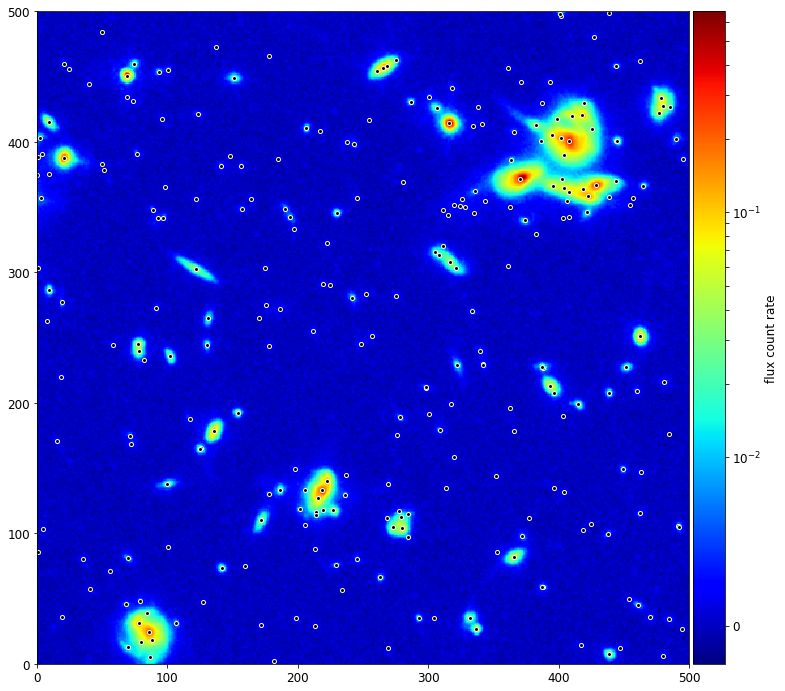

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(image_h, interpolation='nearest', cmap='jet', norm=SymLogNorm(linthresh=1e-2), origin='lower')
ax.scatter(positions['x'], positions['y'], s=16, edgecolor='white', facecolor='black')
#ax.set_title("Final positions")
ax.set_ylim((0, 500))
ax.set_xlim((0, 500))
fig.colorbar(im, cax=cax, orientation='vertical', label="flux count rate")
fig.savefig("images/final-positions.png", bbox_inches='tight')
fig.savefig("images/final-positions.pdf", bbox_inches='tight')

In [43]:
print(len(positions))

278


## Export catalog

In [44]:
MMSE.catalog.to_pickle('data/xdf_f160-f814_3020-3470.pkl')

## Comparison to other catalogs

In [45]:
from astropy.coordinates import SkyCoord
from astropy import units as u
from astroquery.vizier import Vizier
Vizier.ROW_LIMIT = -1

Bouwens+ 2015 catalog (see also http://vizier.cfa.harvard.edu/viz-bin/VizieR?-source=J/ApJ/803/34)

In [46]:
Bouwens_Cat = Vizier.get_catalogs(catalog="J/ApJ/803/34")[0]

Guo+ 2013 catalog (CANDELS GOODS-S catalog, see also http://vizier.cfa.harvard.edu/viz-bin/VizieR?-source=J/ApJS/207/24)

In [47]:
CANDELS_Cat = Vizier.get_catalogs(catalog="J/ApJS/207/24")[0]
# just keep galaxies and good objects
idx_good_sources = (CANDELS_Cat['Q'] == 0.0)
idx_galaxy_sources = (CANDELS_Cat['S_G'] < 0.95)
CANDELS_Cat = CANDELS_Cat[idx_good_sources]

Finkelstein+ 2015 catalog (see also http://vizier.cfa.harvard.edu/viz-bin/VizieR?-source=J/ApJ/810/71)

In [48]:
Finkelstein_Cat = Vizier.get_catalogs(catalog="J/ApJ/810/71")[0]

3D-HST catalog (see also http://adsabs.harvard.edu/abs/2014ApJS..214...24S)

In [49]:
threeDHST_Cat = np.genfromtxt(os.path.join(base, '3DHST_combined_catalog.dat'), names=True)

## Bouwens

In [50]:
bouw = SkyCoord(ra=Bouwens_Cat['RAJ2000'], dec=Bouwens_Cat['DEJ2000'], unit=(u.hourangle, u.deg))
# origin: coordinate in the upper left corner of the image, for Numpy should be 0
xp, yp = bouw.to_pixel(wcs_h, origin=0)
bouw_original = zip(xp, yp)

In [51]:
bouw_cutout = np.zeros((len(xp),2))
for (i,t) in enumerate(bouw_original):
    bouw_cutout[i,:] = cutout_h.to_cutout_position(t)

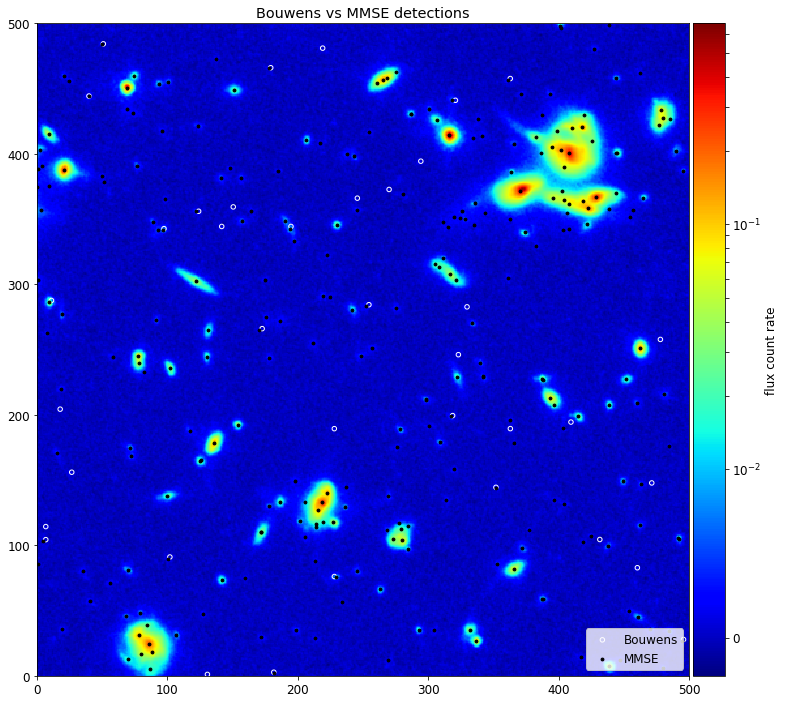

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(image_h, interpolation='nearest', cmap='jet', norm=SymLogNorm(linthresh=1e-2), origin='lower')
ax.scatter(bouw_cutout[:,0], bouw_cutout[:,1], s=20, edgecolor='white', facecolor='none', label="Bouwens")
ax.scatter(positions['x'], positions['y'], s=8, edgecolor='black', facecolor='black', label="MMSE")
ax.set_ylim((0, 500))
ax.set_xlim((0, 500))
ax.set_title("Bouwens vs MMSE detections")
ax.legend(loc='lower right')
fig.colorbar(im, cax=cax, orientation='vertical', label="flux count rate")
fig.savefig("images/bouwens-mmse.png", bbox_inches='tight')
fig.savefig("images/bouwens-mmse.pdf", bbox_inches='tight')

## Guo

In [53]:
guo = SkyCoord(ra=CANDELS_Cat['RAJ2000'], dec=CANDELS_Cat['DEJ2000'], unit=(u.hourangle, u.deg))
# origin: coordinate in the upper left corner of the image, for Numpy should be 0
xp, yp = guo.to_pixel(wcs_h, origin=0)
guo_original = zip(xp, yp)

In [54]:
guo_cutout = np.zeros((len(xp),2))
for (i,t) in enumerate(guo_original):
    guo_cutout[i,:] = cutout_h.to_cutout_position(t)

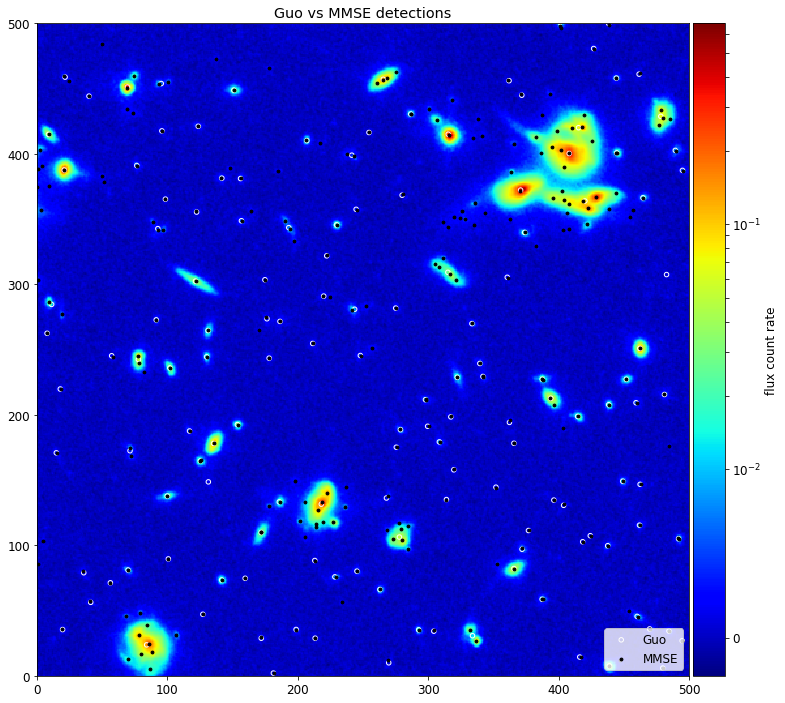

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(image_h, interpolation='nearest', cmap='jet', norm=SymLogNorm(linthresh=1e-2), origin='lower')
ax.scatter(guo_cutout[:,0], guo_cutout[:,1], s=20, edgecolor='white', facecolor='none', label="Guo")
ax.scatter(positions['x'], positions['y'], s=8, edgecolor='black', facecolor='black', label="MMSE")
ax.set_ylim((0, 500))
ax.set_xlim((0, 500))
ax.set_title("Guo vs MMSE detections")
ax.legend(loc='lower right')
fig.colorbar(im, cax=cax, orientation='vertical', label="flux count rate")
fig.savefig("images/guo-mmse.png", bbox_inches='tight')
fig.savefig("images/guo-mmse.pdf", bbox_inches='tight')

## Finkelstein

In [56]:
fink = SkyCoord(ra=Finkelstein_Cat['RAJ2000'], dec=Finkelstein_Cat['DEJ2000'], unit=(u.hourangle, u.deg))
# origin: coordinate in the upper left corner of the image, for Numpy should be 0
xp, yp = fink.to_pixel(wcs_h, origin=0)
fink_original = zip(xp, yp)

In [57]:
fink_cutout = np.zeros((len(xp),2))
for (i,t) in enumerate(fink_original):
    fink_cutout[i,:] = cutout_h.to_cutout_position(t)

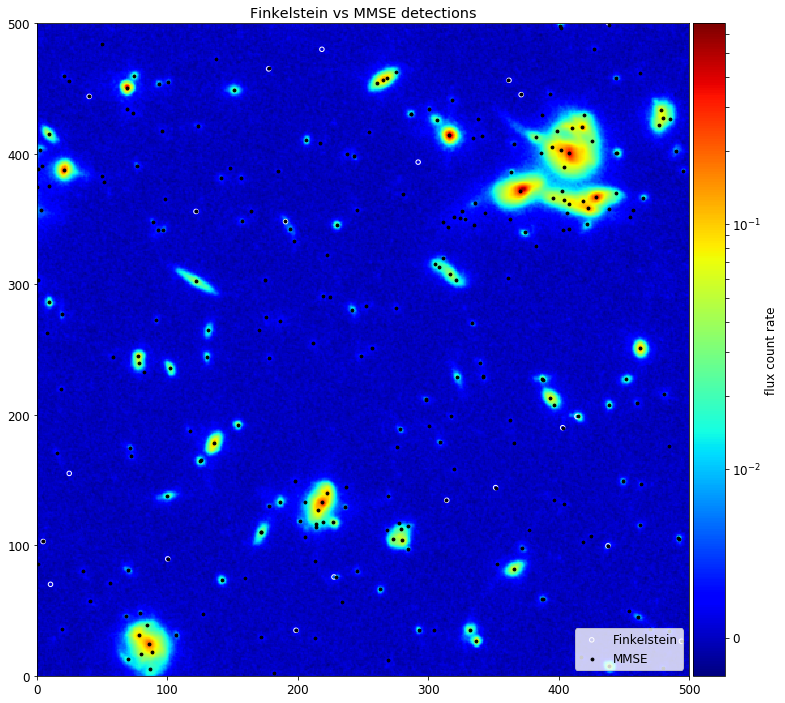

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(image_h, interpolation='nearest', cmap='jet', norm=SymLogNorm(linthresh=1e-2), origin='lower')
ax.scatter(fink_cutout[:,0], fink_cutout[:,1], s=20, edgecolor='white', facecolor='none', label="Finkelstein")
ax.scatter(positions['x'], positions['y'], s=8, edgecolor='black', facecolor='black', label="MMSE")
ax.set_ylim((0, 500))
ax.set_xlim((0, 500))
ax.set_title("Finkelstein vs MMSE detections")
ax.legend(loc='lower right')
fig.colorbar(im, cax=cax, orientation='vertical', label="flux count rate")
fig.savefig("images/finkelstein-mmse.png", bbox_inches='tight')
fig.savefig("images/finkelstein-mmse.pdf", bbox_inches='tight')

## 3D-HST

In [59]:
hst = SkyCoord(ra=threeDHST_Cat['ra'], dec=threeDHST_Cat['dec'], unit=(u.deg, u.deg))
# origin: coordinate in the upper left corner of the image, for Numpy should be 0
xp, yp = hst.to_pixel(wcs_h, origin=0)
hst_original = zip(xp, yp)

In [60]:
hst_cutout = np.zeros((len(xp),2))
for (i,t) in enumerate(hst_original):
    hst_cutout[i,:] = cutout_h.to_cutout_position(t)

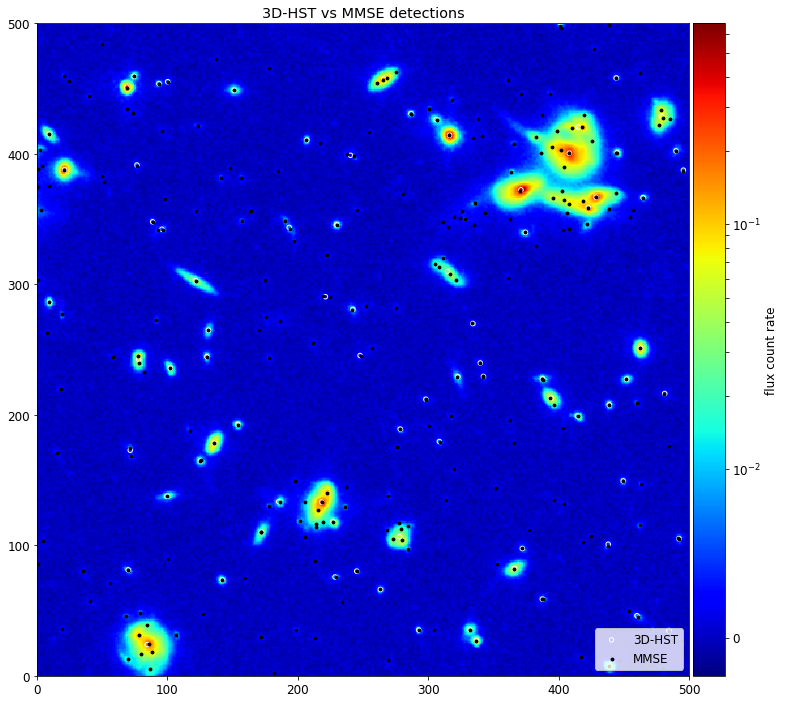

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(image_h, interpolation='nearest', cmap='jet', norm=SymLogNorm(linthresh=1e-2), origin='lower')
ax.scatter(hst_cutout[:,0], hst_cutout[:,1], s=20, edgecolor='white', facecolor='none', label="3D-HST")
ax.scatter(positions['x'], positions['y'], s=8, edgecolor='black', facecolor='black', label="MMSE")
ax.set_ylim((0, 500))
ax.set_xlim((0, 500))
ax.set_title("3D-HST vs MMSE detections")
ax.legend(loc='lower right')
fig.colorbar(im, cax=cax, orientation='vertical', label="flux count rate")
fig.savefig("images/3dhst-mmse.png", bbox_inches='tight')
fig.savefig("images/3dhst-mmse.pdf", bbox_inches='tight')

## All catalogs

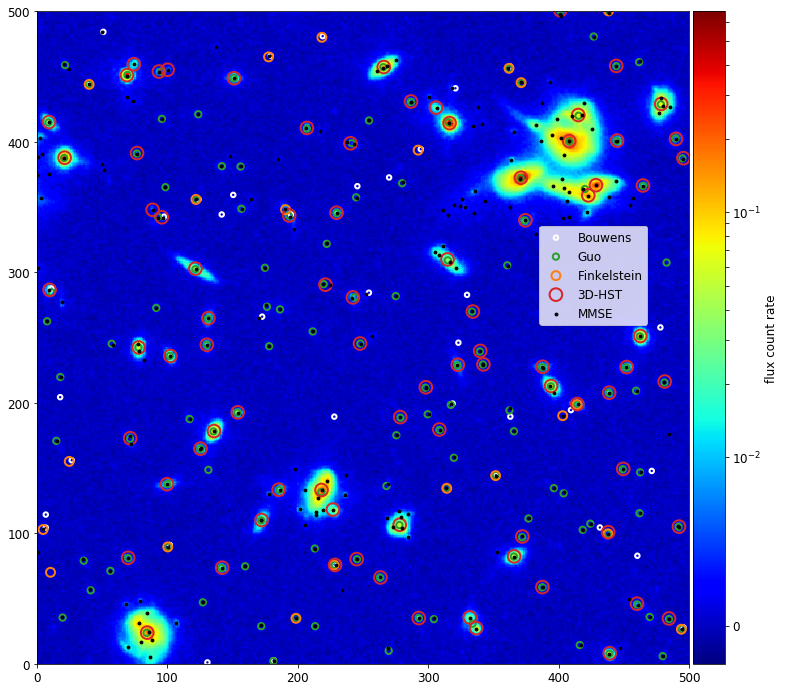

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(image_h, interpolation='nearest', cmap='jet', norm=SymLogNorm(linthresh=1e-2), origin='lower')
ax.scatter(bouw_cutout[:,0], bouw_cutout[:,1], s=20, linewidths=2, edgecolor='white', facecolor='none', label="Bouwens")
ax.scatter(guo_cutout[:,0], guo_cutout[:,1], s=40, linewidths=2, edgecolor='C2', facecolor='none', label="Guo")
ax.scatter(fink_cutout[:,0], fink_cutout[:,1], s=80, linewidths=2, edgecolor='C1', facecolor='none', label="Finkelstein")
ax.scatter(hst_cutout[:,0], hst_cutout[:,1], s=160, linewidths=2, edgecolor='C3', facecolor='none', label="3D-HST")
ax.scatter(positions['x'], positions['y'], s=8, edgecolor='black', facecolor='black', label="MMSE")
ax.set_ylim((0, 500))
ax.set_xlim((0, 500))
#ax.set_title("All vs MMSE detections")
ax.legend(loc=(0.77, 0.52))
fig.colorbar(im, cax=cax, orientation='vertical', label="flux count rate")
fig.savefig("images/all-mmse.png", bbox_inches='tight')
fig.savefig("images/all-mmse.pdf", bbox_inches='tight')

## Detection fraction

In [63]:
def detected_fraction(catalog, positions, threshold=5):
    detected = 0
    for i in range(catalog.shape[0]):
        xi, yi = catalog[i,:]
        ds = [np.linalg.norm(catalog[i,:]-positions[j,:]) for j in range(positions.shape[0])]
        md = np.min(ds)
        if md < threshold:
            detected += 1
    return detected/catalog.shape[0]

In [64]:
catalogs = [bouw_cutout, guo_cutout, fink_cutout, hst_cutout]
detection_fractions = []
for cat in catalogs:
    indx = np.logical_and(cat[:,0]>=0, cat[:,0]<=500)
    indy = np.logical_and(cat[:,1]>=0, cat[:,1]<=500)
    ind = np.logical_and(indx, indy)
    detection_fractions.append(detected_fraction(cat[ind,:], positions.as_matrix()))

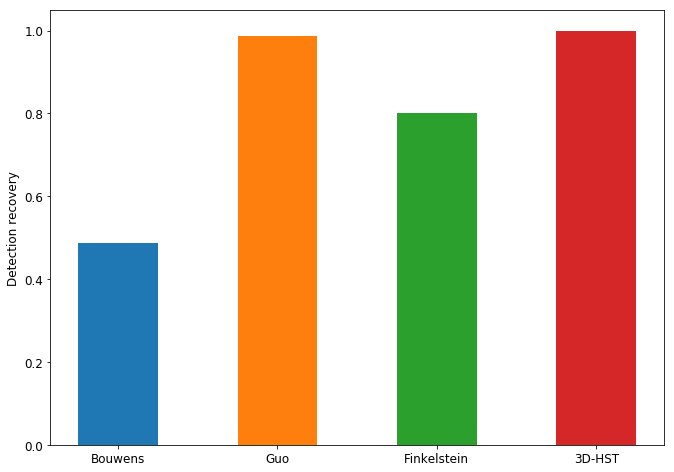

In [65]:
colors = ['C0', 'C1', 'C2', 'C3']
labels = ['Bouwens', 'Guo', 'Finkelstein', '3D-HST']
fig, ax = plt.subplots(1, 1, figsize=(11, 8))
ax.bar(np.arange(4), detection_fractions, width=0.5,
        color=colors, tick_label=labels)
ax.set_ylabel("Detection recovery")
fig.savefig('images/detection-recovery.png', bbox_inches='tight')
fig.savefig('images/detection-recovery.pdf', bbox_inches='tight')

In [66]:
trs = np.arange(1, 50)
dfs = np.zeros((len(trs), len(catalogs)))
for (i,cat) in enumerate(catalogs):
    indx = np.logical_and(cat[:,0]>=0, cat[:,0]<=500)
    indy = np.logical_and(cat[:,1]>=0, cat[:,1]<=500)
    ind = np.logical_and(indx, indy)
    for (j,t) in enumerate(trs):
        dfs[j,i] = detected_fraction(cat[ind,:], positions.as_matrix(), threshold=t)

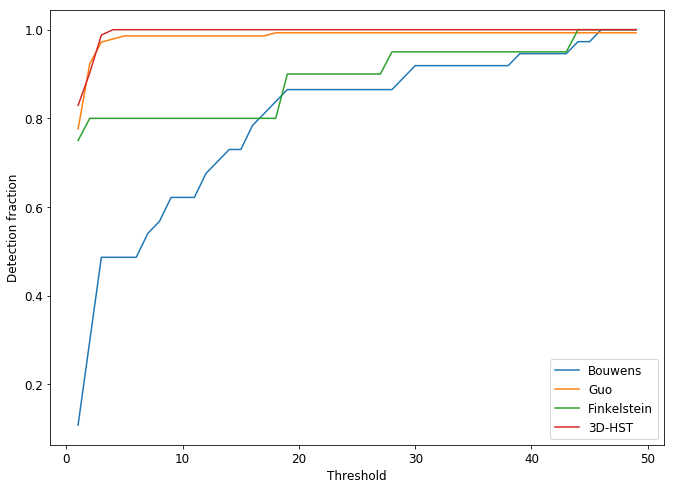

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(11, 8))
for i in range(len(catalogs)):
    ax.plot(trs, dfs[:,i], color=colors[i], label=labels[i])
ax.set_xlabel("Threshold")
ax.set_ylabel("Detection fraction")
ax.legend(loc="lower right")
fig.savefig('images/detection-threshold.png', bbox_inches='tight')
fig.savefig('images/detection-threshold.pdf', bbox_inches='tight')

In [68]:
for (i,cat) in enumerate(catalogs):
    indx = np.logical_and(cat[:,0]>=0, cat[:,0]<=500)
    indy = np.logical_and(cat[:,1]>=0, cat[:,1]<=500)
    ind = np.logical_and(indx, indy)
    print("{}: {}".format(labels[i], len(cat[ind,:])))

Bouwens: 37
Guo: 143
Finkelstein: 20
3D-HST: 82
